In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
df = pd.read_csv('new_training_data_31_08_2022.csv')
df_n = pd.read_csv('all_reject_data.csv')


Изначально 27 % банкротсв во всем датафрейме

Хорошо бы знать текущие наработки организации по определению патернов отказа, это бы помогло в формировании признаков.
Возможно помогла бы информация о состоянии доходов (прямая или косвенная) для оценки отношения дохода к долгу.
Наличия долгов в других организациях, судебных приставов и пр.
Наличия трудоустройства
Личные данные могут также быть полезны - семейное положение, наличие детей, постоянного места регистрации

длительность просроченных 
Количество последовательных кредитов без погашения предыдущих
Если как-то можно узнать на что идут займы - если на комуналку и продукты, то это может рассматриваться как фактор риска
Займы погаешные досрочно могут быть позитивным фактором
РАбота на улучшением модели конечно важно, но от важность новых хороших признаков больше

Не ясно по поводу закрытых кредитов. К примеру "Количество всех активных кредитов, открытых за последний месяц" - "Количество закрытых кредитов, которые были открыты за последний месяц". Казалось бы меньше нуля значений быть не должно, но они есть. Возможно "закрытые" считаются вместе с активными и не активными, или же закрытые имеется ввиду из неактивных. Но в таком случае почему мы считаем закрытые неактивные кредиты, и не считаем отдельно активные закрытые кредиты. Помимо этого есть еще "невозвращенные" и "просроченные".  Кажется, что помогло бы небольшое описание используемых терминов, чтобы сразу было понятно, что имеется ввиду. Из подобного рода имелись сложности в понимании истории движения 

Есть несколько вопросов.
1. Вообще не очевидно что такое есть target.
2. Ratio_sum_outstanding_to_open_sum (Отношение суммы просрочки по всем кредитам к сумме взятых кредитов за всю историю). Можно было бы применить обратные преобразования, и потом найти сумму просрочки по всем кредитам, однако, суммы взятых кредитов за весь период нет (есть только за 12,3 и 1 месяц). 
* Cодержит 4200 срок < 0. Хотя по идеи там не должно быть таких значений.  
* Если сумма просрочки больше суммы кредитов, то это как-будто явный признак состояния банкротства, однако таргет (по значению этого признака >1) делится в пропорции 30/70...Что тоже странно. Хотя вероятно это показатель уже после стандартизации.
3. overall_worst_overdue_state_12 -  в описании задания не указано, что означает данный термин, судя по названию некая общая наибольшая просрочка за последние 12 месяцев... Также нет описания у ratio_pattern_len_to_pattern_3, ratio_pattern_len_to_pattern_4.
4. ratio_overdue_loans_3_to_12 - не содержит никакой информации (0 и nan)
5. Очень странно, что overdue_loans_3, overdue_loans_12 принимает только нулевые значения, поэтому метрики отношений, такие как ratio_overdue_loans_3_to_12 также принимают нулевые значения.
6. Не понятно почему средняя просрочка имеется, по всем временным интервалам, а количество просроченных кредитов везде нули. Для себя разграничил так - просроченные кредиты это те, по которым прошел срок по договору, а просрочка это просрочка платежа на n дней

In [3]:
all_col = set(df.columns)

Разделим параметры на несколько групп и рассмотрим их по отдельности:
1. Параметры количества, сумм и типов кредитных продуктов
2. Параметры просрочки
3. Cуммарные параметры и отношения и прочие

In [4]:
# Параметры количества, сумм и типов кредитных продуктов
q_cols = ['micro_loans_active_100','is_type_micro_100','is_active_type_micro_100',
        'micro_loans_active_12','is_type_micro_12','is_active_type_micro_12',
        'micro_loans_active_3','is_type_micro_3','is_active_type_micro_3',
        'micro_loans_active_1','is_type_micro_1','is_active_type_micro_1',
        'open_sum_12','is_type_credit_card_12','is_active_type_credit_card_12','is_type_consumer_12', 'is_active_type_consumer_12',
        'open_sum_3','is_type_credit_card_3', 'is_active_type_credit_card_3', 'is_type_consumer_3', 'is_active_type_consumer_3',
        'open_sum_1','is_type_credit_card_1','is_active_type_credit_card_1','is_type_consumer_1','is_active_type_consumer_1',
        'is_active_100','is_active_12','is_active_3','is_active_1',
        'is_type_consumer_100','is_type_credit_card_100','is_active_type_consumer_100','is_active_type_credit_card_100']


# Параметры просрочки
d_cols = ['ratio_history_100','ratio_history_12','ratio_history_3','ratio_history_1',
          'mean_delay_100_with_lag','mean_delay_12_with_lag','mean_delay_3_with_lag','mean_delay_1_with_lag','ratio_mean_delay_3_to_12',
         'ratio_pattern_len_to_pattern_1','ratio_pattern_len_to_pattern_2','ratio_pattern_len_to_pattern_3','ratio_pattern_len_to_pattern_4','ratio_pattern_len_to_pattern_bad_len',
         'ratio_overdue_loans_3_to_12',
         'is_lost_100','is_lost_12','is_lost_3','is_lost_1',
         'isnt_active_100','isnt_active_12','isnt_active_3','isnt_active_1',
         'open_loan_median','close_loan_median','overdue_loans_12','overdue_loans_3','time_to_lastcredit_closeddt']


# Cуммарные параметры и отношения и прочие
a_cols = ['age','count_all_credits','lastcredit',
          'fraction_last_x_12','fraction_last_x_3','fraction_last_x_1','ratio_all_microloans_3_to_12',
          'last_microloan_openeddt','time_to_lastcredit_closeddt',
         'overall_worst_overdue_state_12','ratio_sum_outstanding_to_open_sum']


In [5]:
def getDescription(df): 
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all',percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
).transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['1%'] = desc.loc[:, '1%'].values
    summ['5%'] = desc.loc[:, '5%'].values
    summ['25%'] = desc.loc[:, '25%'].values
    summ['50%'] = desc.loc[:, '50%'].values
    summ['75%'] = desc.loc[:, '75%'].values
    summ['95%'] = desc.loc[:, '95%'].values
    summ['99%'] = desc.loc[:, '99%'].values
    return summ

In [6]:
def hist_plot(feature,bin=30, X_log =False, f_log = False):  
    
    if f_log == False:
        
        plt.figure(figsize=(6, 4))
        y_1 = df[df['target'] == 1][feature]
        y_2 = df[df['target'] == 0][feature]

        sns.histplot(x=y_1, weights=np.ones_like(y_1) * 100 / len(y_1), color='#F72585', label='Target 1',bins=bin)
        sns.histplot(x=y_2, weights=np.ones_like(y_2) * 100 / len(y_2), color='#4CC9F0', label='Target 0',bins=bin)
        if X_log ==True:

            plt.xscale('log')
            plt.title('Распределение по таргету')
            plt.xlabel(feature)
            plt.ylabel('%')
            plt.legend()
            plt.show()

        else:
            plt.title('Распределение по таргету')
            plt.xlabel(feature)
            plt.ylabel('%')
            plt.legend()
            plt.show()
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        y_1 = df[df['target'] == 1][feature]
        y_2 = df[df['target'] == 0][feature]
        sns.histplot(x=y_1, weights=np.ones_like(y_1) * 100 / len(y_1), color='#F72585', label='Target 1',bins=bin,ax=axes[0])
        sns.histplot(x=y_2, weights=np.ones_like(y_2) * 100 / len(y_2), color='#4CC9F0', label='Target 0',bins=bin,ax=axes[0])
        axes[0].set_title('Распределение по таргету')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Процент (%)')
        axes[0].legend()
        
        y_11 = np.log(y_1)
        y_22 = np.log(y_2)
        sns.histplot(x=y_11, weights=np.ones_like(y_11) * 100 / len(y_11), color='#F72585', label='Target 1',bins=bin,ax=axes[1])
        sns.histplot(x=y_22, weights=np.ones_like(y_22) * 100 / len(y_22), color='#4CC9F0', label='Target 0',bins=bin,ax=axes[1])
        axes[1].set_title('Логарифмическое распределение по таргету')
        axes[1].set_xlabel('Log(' + feature + ')')
        axes[1].set_ylabel('Процент (%)')
        axes[1].legend()
        plt.show() 

In [7]:
end_color = "#F72585"
start_color = "#4361EE"
colors = [start_color, "white", end_color] 
n_bins = 100  
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

def show_map(df):
    fig, ax = plt.subplots(figsize=(12, 12))

    # Создание тепловой карты с настраиваемой цветовой картой
    heatmap = sns.heatmap(
        df.corr(numeric_only=True).round(2),
        annot=True,
        square=True,
        cmap=cmap,  
        cbar_kws={"fraction": 0.01},
        linewidth=2
    )

    heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )

    plt.show()

## Описание портфеля

### ВЫВОДЫ

1. На текущий момент, исходя из общего количества кредитов открытых за всё время, преобладает доля кредитов по микрозаймам -  84% (по Активным).
2. Если рассматривать каждый кредитный продукт в отдельности по параметру "Активности кредита", то наибольшие значения у типа займа "кредитная карта" 65.5%
3. Если рассматривать динамику в разрезе представленных периодов по активным кредитам, то можно отметить:
* Имеется тенденция роста доли микрозаймов в денежном выражении
* В количественном выражении динамика схожая, однако не такая очевидная
* По всей видимости открытия кредитов типа "Кредитная карта" и "Потребительский" более имели место на периоде ранее 4 месяцев назад. Данные выводы подтверждаются среднемесячным приростом долговой массы, а также количества выданных кредитов в разрезе различных типов продуктов - существенный рост "Микрозаймов"

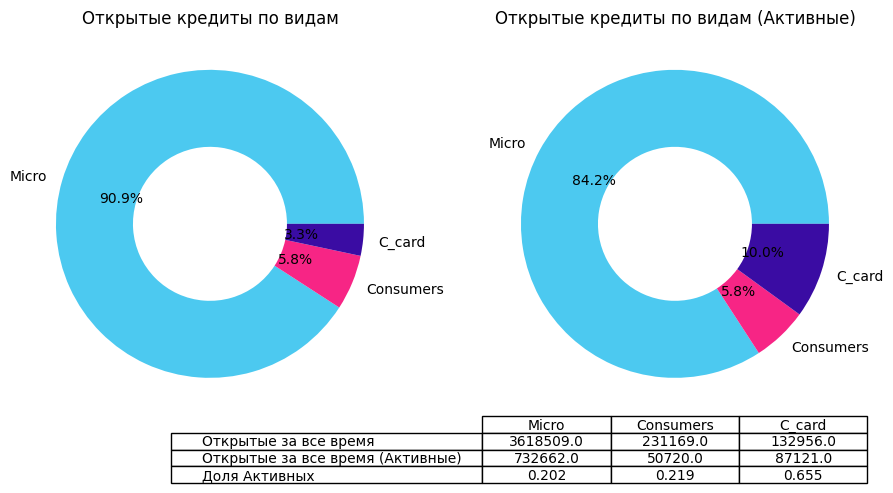

In [8]:
fig,ax = plt.subplots(1,2) 
fig.set_size_inches(11,5) 

colors = ['#4CC9F0', '#F72585', '#3A0CA3']

p1 = df.is_type_micro_100.sum()
p2 = df.is_type_consumer_100.sum()
p3 = df.is_type_credit_card_100.sum()

vals = [p1/(p1+p2+p3),p2/(p1+p2+p3),p3/(p1+p2+p3)]
labels = ['Micro', 'Consumers','C_card']
ax[0].pie(vals, labels = labels,autopct='%1.1f%%', wedgeprops = dict(width =0.5),colors=colors)
ax[0].set_title('Открытые кредиты по видам')

p4 = df.is_active_type_micro_100.sum()
p5 = df.is_active_type_consumer_100.sum()
p6 = df.is_active_type_credit_card_100.sum()

vals = [p4/(p4+p5+p6),p5/(p4+p5+p6),p6/(p4+p5+p6)]
labels = ['Micro', 'Consumers','C_card']
ax[1].pie(vals, labels = labels,autopct='%1.1f%%', wedgeprops = dict(width =0.5),colors=colors)
ax[1].set_title(f'Открытые кредиты по видам (Активные)')

cell_text = [[p1, p2, p3], [p4, p5, p6],[round(p4/p1,3),round(p5/p2,3),round(p6/p3,3)]]
rows = ['Открытые за все время', 'Открытые за все время (Активные)', 'Доля Активных']
columns = ['Micro', 'Consumers', 'C_card']
table = plt.table(cellText=cell_text, rowLabels=rows, colLabels=columns, loc='bottom', cellLoc='center')

plt.show()


#### Вывод: 
1. На текущий момент, исходя из общего количества кредитов, преобладает доля кредитов по микрозаймам -  84% (по Активным).
2. Если рассматривать каждый кредитный продукт в отдельности по параметру "Активности кредита", то наибольшие значения у типа займа "кредитная карта" 65.5%

_ДИНАМИКА ИЗМЕНЕНИЯ ПОРТФЕЛЯ_

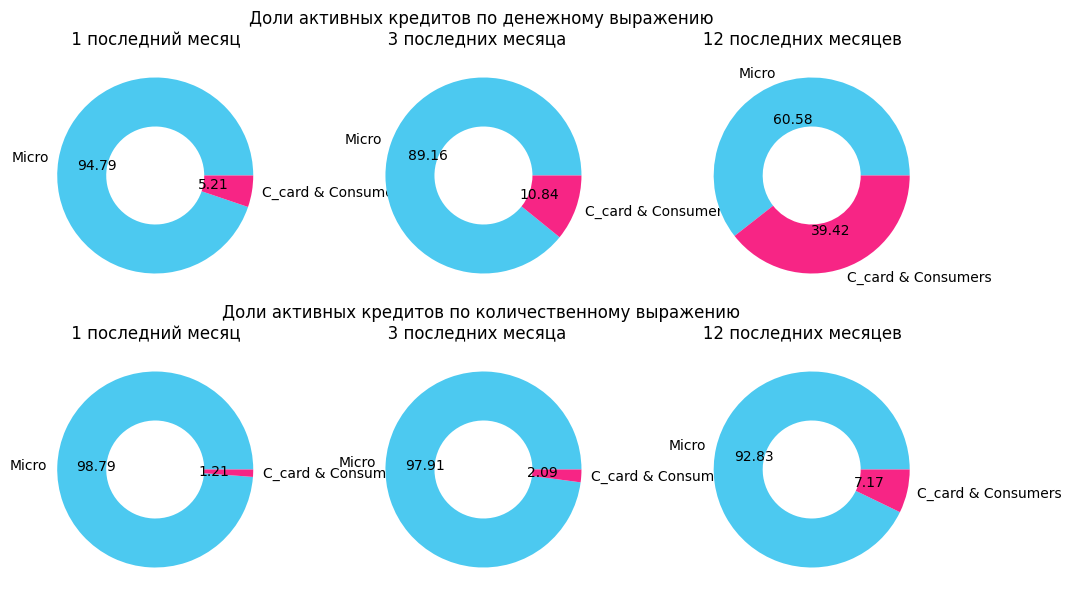

In [9]:
fig,ax = plt.subplots(2,3) 
fig.set_size_inches(12,7) 

colors = ['#4CC9F0', '#F72585']
# через деньги
p1 = df.micro_loans_active_1.sum()
p2 = df.open_sum_1.sum() - df.micro_loans_active_1.sum()
vals = [p1/(p1+p2),p2/(p1+p2)]
labels = ['Micro','C_card & Consumers']
ax[0][0].pie(vals, labels = labels,autopct ='%.2f', wedgeprops = dict(width =0.5),colors=colors)

p1 = df.micro_loans_active_3.sum()
p2= df.open_sum_3.sum() - df.micro_loans_active_3.sum()
vals = [p1/(p1+p2),p2/(p1+p2)]
labels = ['Micro','C_card & Consumers']
ax[0][1].pie(vals, labels = labels,autopct ='%.2f', wedgeprops = dict(width =0.5),colors=colors)


p1 = df.micro_loans_active_12.sum()
p2 = df.open_sum_12.sum() - df.micro_loans_active_12.sum()
vals = [p1/(p1+p2),p2/(p1+p2)]
labels = ['Micro','C_card & Consumers']
ax[0][2].pie(vals, labels = labels,autopct ='%.2f', wedgeprops = dict(width =0.5),colors=colors)

# через количество
p1 = df.is_active_type_micro_1.sum()
p2 = df.is_active_1.sum() - df.is_active_type_micro_1.sum()
vals = [p1/(p1+p2),p2/(p1+p2)]
labels = ['Micro','C_card & Consumers']
ax[1][0].pie(vals, labels = labels,autopct ='%.2f', wedgeprops = dict(width =0.5),colors=colors)

p1 = df.is_active_type_micro_3.sum()
p2= df.is_active_3.sum() - df.is_active_type_micro_3.sum()
vals = [p1/(p1+p2),p2/(p1+p2)]
labels = ['Micro','C_card & Consumers']
ax[1][1].pie(vals, labels = labels,autopct ='%.2f', wedgeprops = dict(width =0.5),colors=colors)

p1 = df.is_active_type_micro_12.sum()
p2 = df.is_active_12.sum() - df.is_active_type_micro_12.sum()
vals = [p1/(p1+p2),p2/(p1+p2)]
labels = ['Micro','C_card & Consumers']
ax[1][2].pie(vals, labels = labels,autopct ='%.2f', wedgeprops = dict(width =0.5),colors=colors)

ax[0][1].set_title('Доли активных кредитов по денежному выражению \n 1 последний месяц                            3 последних месяца                          12 последних месяцев')
ax[1][1].set_title('Доли активных кредитов по количественному выражению \n 1 последний месяц                            3 последних месяца                          12 последних месяцев')

plt.show()

#### Вывод: 
На текущий момент, исходя из изменения количества активных кредитов, а также динамики её сумарной части, можно заметить тенденцию к тому, что постепенно доля микрозаймов увеличивается, вытесняя другие виды кредитования 

## МИКРОЗАЙМЫ

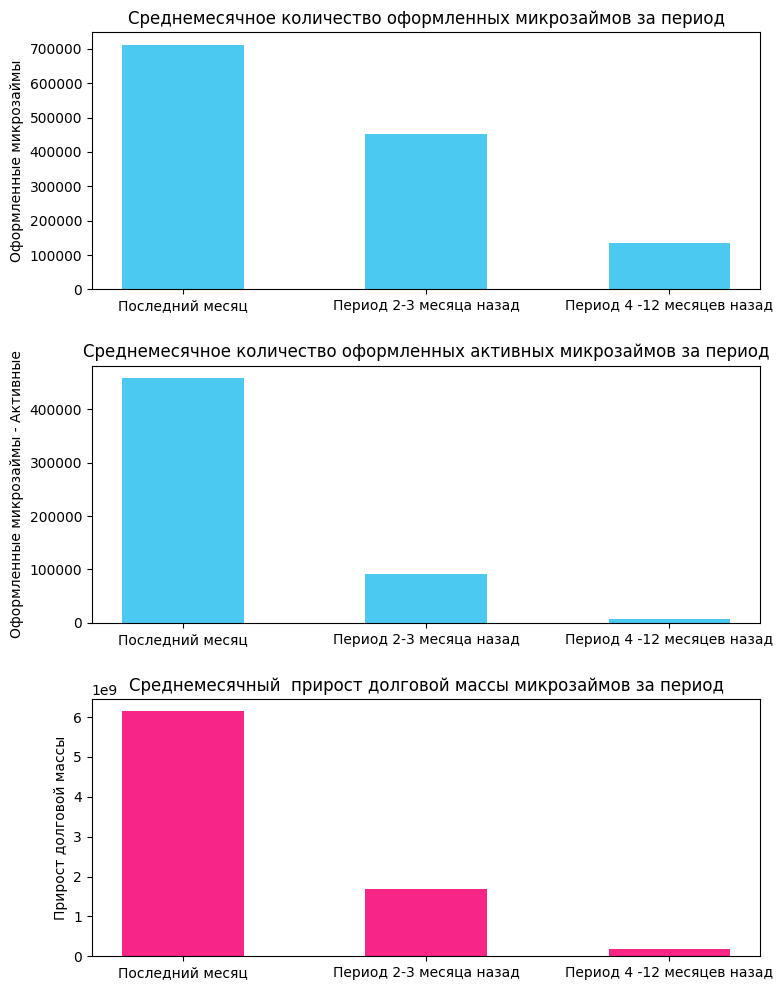

In [10]:
fig,ax = plt.subplots(3,1) # создает фигуру и 4 коорд. оси 
fig.set_size_inches(8,10) # объект фигура. метод задать размер

x =['Последний месяц','Период 2-3 месяца назад','Период 4 -12 месяцев назад']

y = [df.is_type_micro_1.sum(), # оформления в последний месяц
(df.is_type_micro_3 - df.is_type_micro_1).sum()/2, # оформления за 2-3  месяц
(df.is_type_micro_12  - df.is_type_micro_3).sum()/9] # оформления за 4-12  месяцев
ax [0].bar(x,y, width =0.5, linewidth =2,color = '#4CC9F0')
ax [0].set_ylabel('Оформленные микрозаймы')
ax [0].set_title('Среднемесячное количество оформленных микрозаймов за период')


y_2 = [df.is_active_type_micro_1.sum(), # активные кредиты, из оформленных в последний месяц
(df.is_active_type_micro_3 - df.is_active_type_micro_1).sum()/2, # активные кредиты, из оформленных в 2-3 месяц
(df.is_active_type_micro_12 - df.is_active_type_micro_3).sum()/9] # активные кредиты, из оформленных  за 4-12  месяцев
ax [1].bar(x,y_2, width =0.5, linewidth =2,color = '#4CC9F0')
ax [1].set_ylabel('Оформленные микрозаймы - Активные')
ax [1].set_title('Среднемесячное количество оформленных активных микрозаймов за период')


y_3 = [df.micro_loans_active_1.sum(), # cумма кредитов из оформленных в последний месяц
(df.micro_loans_active_3 - df.micro_loans_active_1).sum()/2, # cумма кредитов, из оформленных в 2-3 месяц
(df.micro_loans_active_12 - df.micro_loans_active_3).sum()/9] # cумма кредитов, из оформленных  за 4-12  месяцев
ax [2].bar(x,y_3, width =0.5, linewidth =2,color = '#F72585')
ax [2].set_ylabel('Прирост долговой массы')
ax [2].set_title('Среднемесячный  прирост долговой массы микрозаймов за период')

plt.tight_layout()
plt.show()


### Выводы
По графикам прироста количества микрозаймов, а также долговой денежной массы  - видно, что темпы существенно выросли в последний месяц. 

## ПОТРЕБИТЕЛЬСКИЕ ЗАЙМЫ И КРЕДИТНЫЕ КАРТЫ

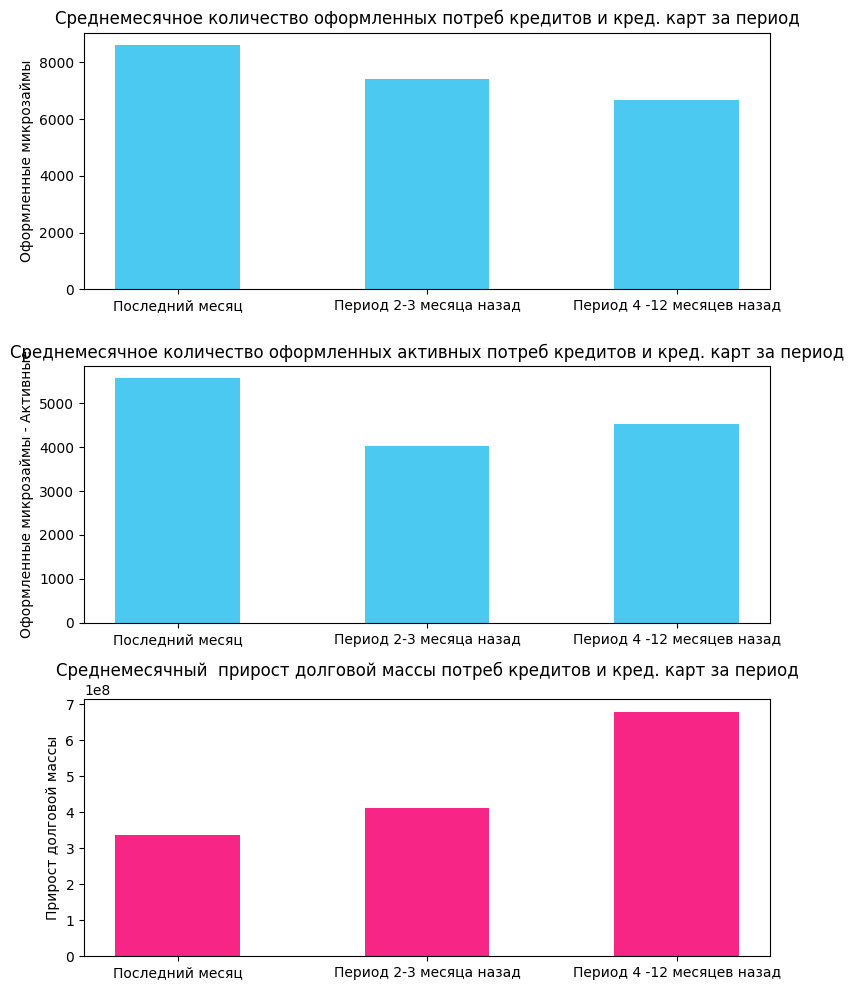

In [11]:
fig,ax = plt.subplots(3,1) # создает фигуру и 4 коорд. оси 
fig.set_size_inches(8,10) # объект фигура. метод задать размер

x =['Последний месяц','Период 2-3 месяца назад','Период 4 -12 месяцев назад']


y = [(df.is_type_credit_card_1 + df.is_type_consumer_1).sum(), # оформления в последний месяц
(df.is_type_credit_card_3 + df.is_type_consumer_3 - (df.is_type_credit_card_1 + df.is_type_consumer_1)).sum()/2, # оформления за 2-3  месяц
(df.is_type_credit_card_12 + df.is_type_consumer_12 - (df.is_type_credit_card_3 + df.is_type_consumer_3)).sum()/9] # оформления за 4-12  месяцев
ax [0].bar(x,y, width =0.5, linewidth =2,color = '#4CC9F0')
ax [0].set_ylabel('Оформленные микрозаймы')
ax [0].set_title('Среднемесячное количество оформленных потреб кредитов и кред. карт за период')
                 
y_2 = [(df.is_active_type_credit_card_1 + df.is_active_type_consumer_1).sum(),# активные кредиты, из оформленных в последний месяц
(df.is_active_type_credit_card_3 + df.is_active_type_consumer_3 - (df.is_active_type_credit_card_1 + df.is_active_type_consumer_1)).sum()/2, # активные кредиты, из оформленных в 2-3 месяц
(df.is_active_type_credit_card_12 + df.is_active_type_consumer_12 - (df.is_active_type_credit_card_3 + df.is_active_type_consumer_3)).sum()/9] # активные кредиты, из оформленных  за 4-12  месяцев
ax [1].bar(x,y_2, width =0.5, linewidth =2,color = '#4CC9F0')
ax [1].set_ylabel('Оформленные микрозаймы - Активные')
ax [1].set_title('Среднемесячное количество оформленных активных потреб кредитов и кред. карт за период')

                 
d1 = df.open_sum_1 - df.micro_loans_active_1
d2 = df.open_sum_3 - df.micro_loans_active_3
d3 = df.open_sum_12 - df.micro_loans_active_12

y_3 = [d1.sum(),# cумма кредитов из оформленных в последний месяц
(d2-d1).sum()/2, # cумма кредитов, из оформленных в 2-3 месяц
(d3-d2).sum()/9] # cумма кредитов, из оформленных  за 4-12  месяцев
                 
ax [2].bar(x,y_3, width =0.5, linewidth =2,color = '#F72585')
ax [2].set_ylabel('Прирост долговой массы')
ax [2].set_title('Среднемесячный  прирост долговой массы потреб кредитов и кред. карт за период')

plt.tight_layout()
plt.show()


### Выводы
По графикам видно снижение среднемесячного количеста оформленных кредитов, а также снижение прироста долговой массы

### Параметры просрочки
Перейдем к параметрам "просрочки" посмотрим на них подробнее

In [12]:
getDescription(df.loc[:,d_cols])

,data type,#missing,%missing,#unique,min,max,1%,5%,25%,50%,75%,95%,99%
ratio_history_100,float64,0,0.000000,1163,0.0,0.666667,0.0,0.0,0.000000,0.000000,0.000000,0.058824,0.150871
ratio_history_12,float64,23,0.054081,790,0.0,0.666667,0.0,0.0,0.000000,0.000000,0.000000,0.031822,0.104426
ratio_history_3,float64,218,0.512591,341,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.038462,0.095238
ratio_history_1,float64,393,0.924075,102,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.100000
mean_delay_100_with_lag,float64,0,0.000000,19782,0.0,120.000000,0.0,0.0,0.431818,2.040179,6.923077,27.781633,47.607783
mean_delay_12_with_lag,float64,0,0.000000,10251,0.0,119.500000,0.0,0.0,0.000000,0.108614,1.000000,6.199389,16.353695
mean_delay_3_with_lag,float64,0,0.000000,5988,0.0,46.736842,0.0,0.0,0.000000,0.000000,0.210526,1.798584,5.272413
mean_delay_1_with_lag,float64,0,0.000000,3296,0.0,18.166667,0.0,0.0,0.000000,0.000000,0.000000,0.690476,1.967060
ratio_mean_delay_3_to_12,float64,2561,6.021773,4353,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.437029,1.000000,1.000000
ratio_pattern_len_to_pattern_1,float64,9,0.021162,49,0.0,1.000000,0.0,0.0,0.000000,0.000000,1.000000,1.000000,1.000000


F:\ANACONDA\envs\py_sp\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


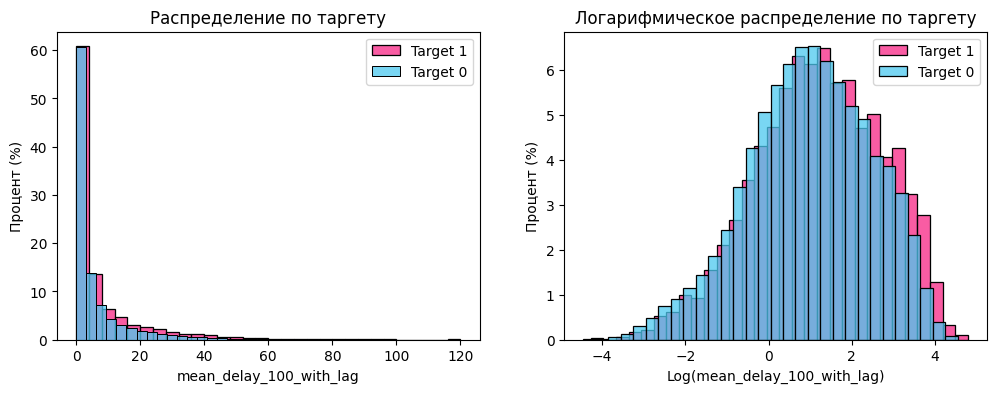

F:\ANACONDA\envs\py_sp\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


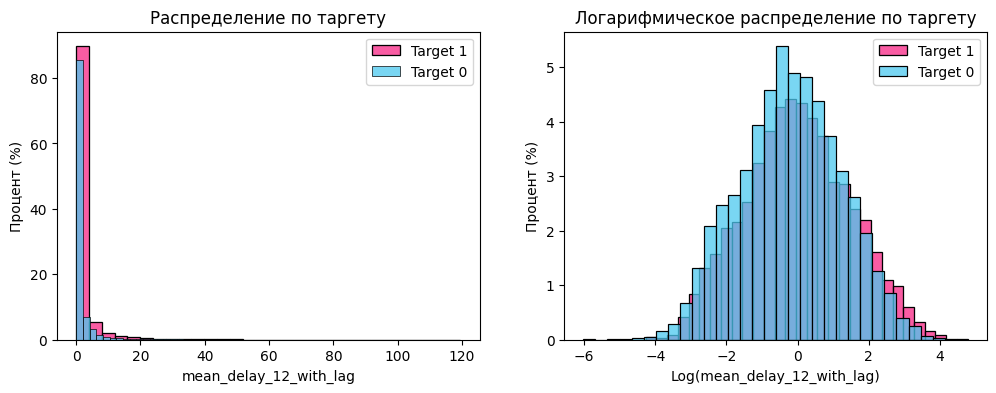

F:\ANACONDA\envs\py_sp\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


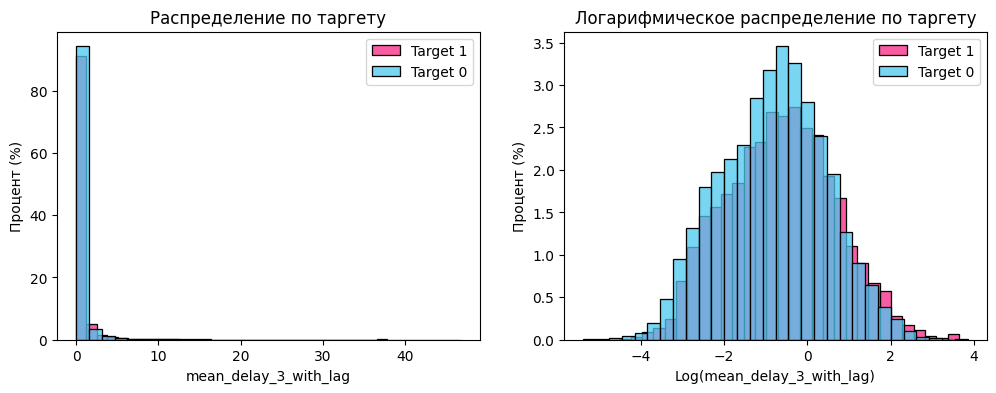

F:\ANACONDA\envs\py_sp\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


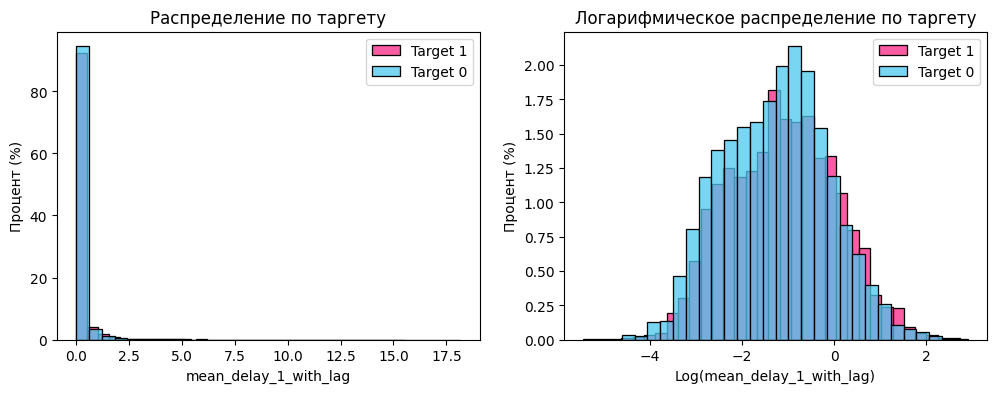

In [13]:
# Рассмотрим время просрочки, применим логарифмическое преобразование

for i in list(['mean_delay_100_with_lag','mean_delay_12_with_lag','mean_delay_3_with_lag','mean_delay_1_with_lag']):
    hist_plot(i,X_log =True,f_log = True)

F:\ANACONDA\envs\py_sp\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


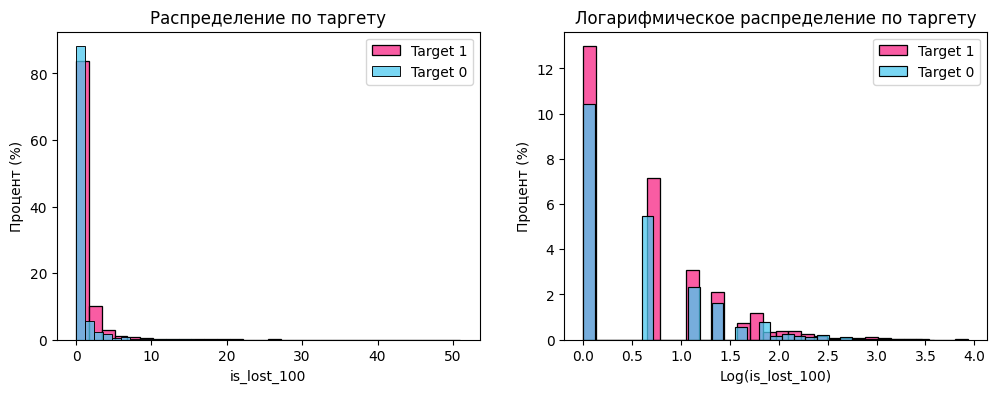

F:\ANACONDA\envs\py_sp\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


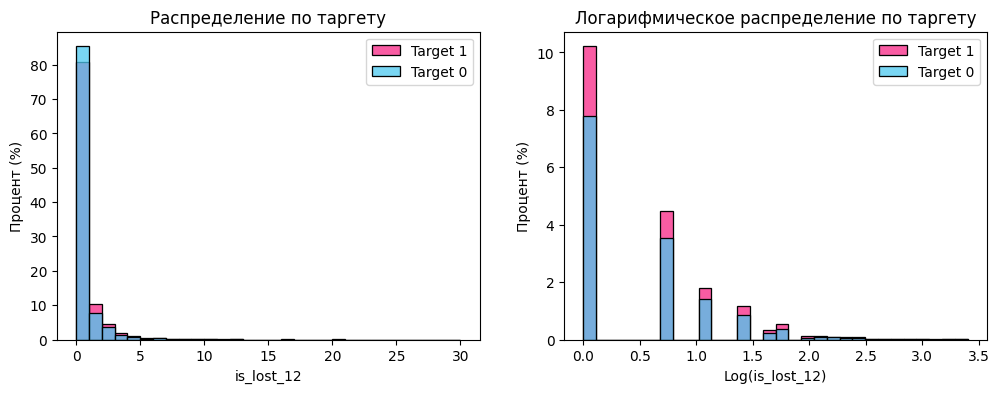

F:\ANACONDA\envs\py_sp\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


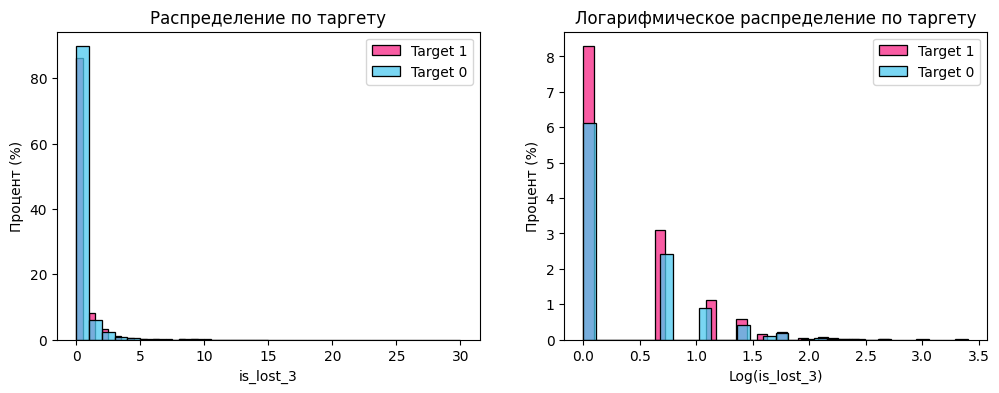

F:\ANACONDA\envs\py_sp\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


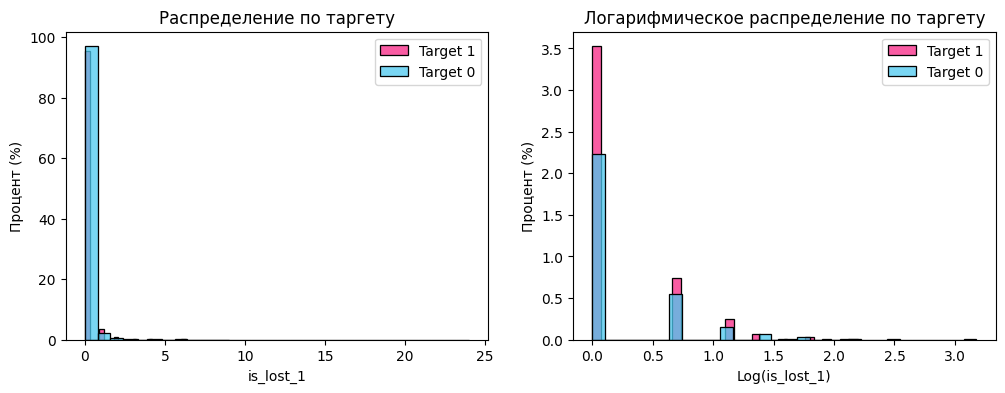

In [14]:
# Рассмотрим невозвращенные кредиты, применим логарифмическое преобразование
for i in list(['is_lost_100','is_lost_12','is_lost_3','is_lost_1']):
    hist_plot(i,X_log =True,f_log = True)

### Выводы
* ratio_history - 99% значений по данным параметрам менее 0.1, а 75% это нулевые значения. Пропуски заполним медианой, т.е. 0.

* mean_delay - распределение в зависимости от таргета почти идентичное, есть небольшая разница в усредненной просрочке за все время, чем меньше период усреднения, тем разница более незначительна.

* ratio_mean_delay_3_to_12  - пропуски связаны с нулевыми значениями в знаменателе. Поэтому заменим пропуски на 0.
* ratio_pattern_len_to_pattern пропуски по клиентам, с time_to_lastcredit_closeddt >40 тыс., кроме того имеются существенное количество пропусков по другим признакам. 9 строк удалим из базы.
* Существенное количество пропусков ratio_overdue_loans_3_to_12 связано с нулевыми значениями в знаменателе (а именно overdue_loans_12). Можно заменить пропуски на 0. Но данный параметр, вообще весь принимает нулевые значения. Поэтому его можно удалить.
* Пропуски в open_loan_median и close_loan_median также пропадут после удаления 9 строк указаных выше.
* overdue_loans_3 и overdue_loans_12 не имеют значений отличных от нуля. Данные признаки можно удалить.
* Для номализации данных возможно будет полезно применить логарифмическое (или аналогичное) преобразование.

### Прочие параметры
Перейдем к параметрам "Прочие" посмотрим на них подробнее

In [15]:
getDescription(df.loc[:,a_cols])

,data type,#missing,%missing,#unique,min,max,1%,5%,25%,50%,75%,95%,99%
age,float64,0,0.000000,58,18.0,75.0,21.000000,23.000000,28.000000,33.000000,39.000000,52.000000,62.000000
count_all_credits,float64,0,0.000000,752,1.0,8577.0,7.000000,16.000000,40.000000,69.000000,116.000000,254.000000,501.000000
lastcredit,float64,0,0.000000,381,1.0,5029.0,1.000000,1.000000,2.000000,4.000000,7.000000,18.000000,103.000000
fraction_last_x_12,float64,0,0.000000,7133,0.0,1.0,0.045455,0.225352,0.666667,0.846154,0.944444,1.000000,1.000000
fraction_last_x_3,float64,0,0.000000,8239,0.0,1.0,0.000000,0.080000,0.296970,0.500000,0.707317,0.916667,1.000000
fraction_last_x_1,float64,0,0.000000,5976,0.0,1.0,0.000000,0.026316,0.112500,0.213333,0.350000,0.611111,0.833333
ratio_all_microloans_3_to_12,float64,32,0.075243,6852,0.0,1.0,0.000000,0.214839,0.446809,0.684211,0.928571,1.000000,1.000000
last_microloan_openeddt,float64,0,0.000000,449,1.0,44778.0,1.000000,1.000000,2.000000,4.000000,7.000000,19.000000,136.000000
time_to_lastcredit_closeddt,float64,0,0.000000,401,0.0,44785.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.720000
overall_worst_overdue_state_12,float64,0,0.000000,7,0.0,120.0,0.000000,0.000000,120.000000,120.000000,120.000000,120.000000,120.000000


### Выводы
* Наиболее интеересный параметр - отношение суммы просрочки. Cодержит 4200 срок < 0. Хотя по идеи там не должно быть таких значений. Предполагаю, что этот параметр после стандартизации. В нём есть значения inf, которые заменю на 0. Как мне казалось он должен иметь существенную связь с таргетом, но нет...
* Наиболее интеересные параметры overall_worst_overdue_state_12. Принимает значение 120 в 85%. Что с ним делать, не очень понятно.

* count_all_credits имеется 67 значений >1000 кредитов. Максимальное  - 8577. Здесь можно подумать над удалением выбросов
* lastcredit также имеются большие значения (макс. - 5029 дней) при медиане в 4 дня.
* last_microloan_openeddt, time_to_lastcredit_closeddt также имеются выбросы


Замена inf и -inf на NaN
df['ratio_sum_outstanding_to_open_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)

Замена NaN на медианное значение
median_value = df['ratio_sum_outstanding_to_open_sum'].median()
df['ratio_sum_outstanding_to_open_sum'].fillna(median_value, inplace=True)

### Немного корреляции

In [16]:
corr_features = []
corr_value =[]

for i in df.columns:
    corr_features.append(i)
    corr_value.append(df[[i,'target']].corr().iloc[0,1])
    
df_corr = pd.DataFrame({'corr_features':corr_features,'corr_value':corr_value})

In [17]:
df_corr.sort_values(by='corr_value',ascending = False).head(10)

,corr_features,corr_value
74,target,1.000000
72,overall_worst_overdue_state_12,0.104457
29,ratio_history_100,0.104187
30,ratio_history_12,0.080347
36,mean_delay_100_with_lag,0.075005
8,is_lost_100,0.061320
32,ratio_history_3,0.054689
37,mean_delay_12_with_lag,0.053987
5,open_loan_median,0.041073
13,is_lost_12,0.040480


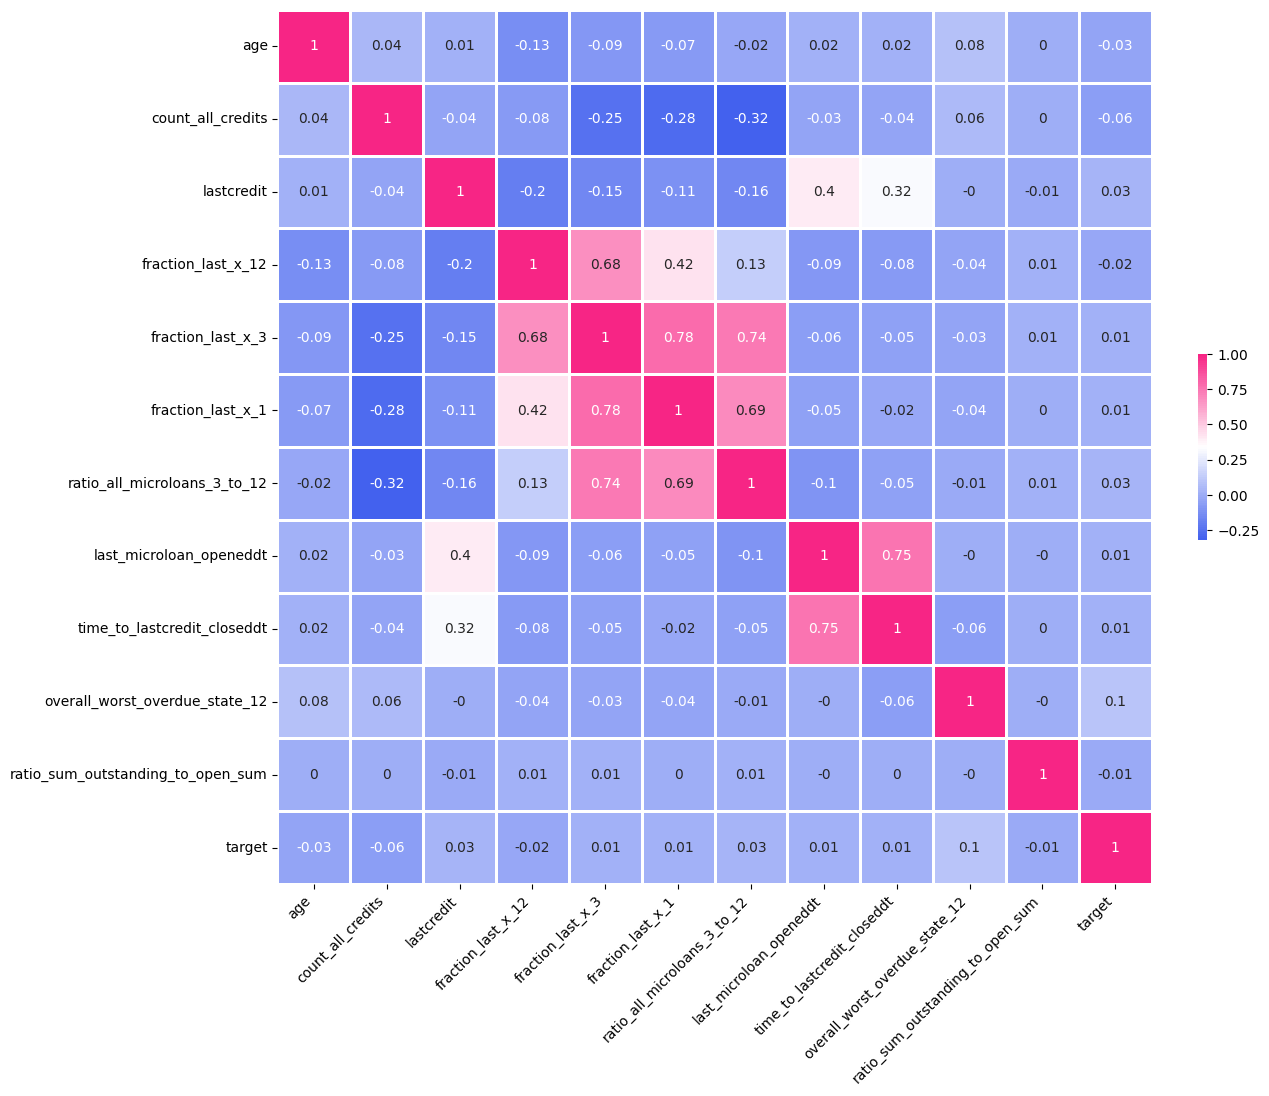

In [18]:
show_map(df.loc[:,a_cols+['target']])

## ПРЕОБРАЗОВАНИЯ

In [42]:
def pretrain(df_1):
    # Удалим колонки
    features_to_drop=['overdue_loans_3','overdue_loans_12','ratio_overdue_loans_3_to_12','Unnamed: 0']
    df_1 = df.drop(features_to_drop, axis =1)

    # Замена nan на 0
    fill_null =  ['ratio_all_microloans_3_to_12', 'ratio_history_12', 'ratio_history_3', 'ratio_history_1','ratio_mean_delay_3_to_12']
    df_1.loc[:,fill_null]=df_1.loc[:,fill_null].fillna(0)

    # Замена inf и -inf на NaN
    df_1['ratio_sum_outstanding_to_open_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)
    # median_value = df_1['ratio_sum_outstanding_to_open_sum'].median()
    # df_1['ratio_sum_outstanding_to_open_sum'].fillna(median_value, inplace=True)
    
    min_value = df_1['ratio_sum_outstanding_to_open_sum'].min()
    df_1['ratio_sum_outstanding_to_open_sum'].fillna(min_value, inplace=True)

    # Уберем 9 строк из базы где много пропущеных значений
    df_1 = df_1[df_1.close_loan_median.notna()]
    return df_1

df_1 =pretrain(df)

### ДОП. ПРИЗНАКИ
    

In [43]:
df_1['n1'] = df_1.is_active_3 - df_1.is_active_type_micro_3
df_1['n2'] = df_1.is_active_1 - df_1.is_active_type_micro_1
df_1['n3'] = df_1.is_active_12 - df_1.is_active_type_micro_12
df_1['n4'] = df_1.n1 - df_1.n2
df_1['m1'] = df_1.is_active_type_micro_1/df_1.is_type_micro_1
df_1['m2'] = df_1.is_active_type_micro_3/df_1.is_type_micro_3
df_1['m3'] = df_1.is_active_type_micro_12/df_1.is_type_micro_12
df_1['m4'] = df_1.is_active_type_micro_100/df_1.is_type_micro_100
df_1['open_active_2'] = df_1.is_active_3 - df_1.is_active_1
df_1['open_active_9'] = df_1.is_active_12 - df_1.is_active_3
df_1['j1'] = (df_1.is_active_1 + df_1.open_active_2/2 + df_1.open_active_9/9)/df_1.is_active_12
df_1['open_sum_active_2'] = df_1.open_sum_3 - df_1.open_sum_1
df_1['open_sum_active_9'] = df_1.open_sum_12 - df_1.open_sum_3
df_1['j2'] = (df_1.is_active_1 + df_1.open_sum_active_2/2 + df_1.open_sum_active_9/9)/df_1.open_sum_12
df_1['j3'] = df_1.is_active_1/ df_1.is_active_12
df_1['j4'] = df_1.is_active_3/ df_1.is_active_12
df_1['j5'] = df_1.isnt_active_3/ df_1.isnt_active_12
df_1 = df_1.fillna(0)

In [44]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer, recall_score
from sklearn.utils.class_weight import compute_class_weight
import optuna
from sklearn.model_selection import KFold
import copy

# Матрица ответов модели
def conf(y_test,y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Создание матрицы ошибок с подписями
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'])  
    plt.yticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'])  
    plt.show()
    print(f'Доля банкротов {conf_matrix[1][0]/(conf_matrix[0][0]+conf_matrix[1][0])}')
    print (f'% Одобрения {(conf_matrix *[[1,0],[1,0]]).sum()/conf_matrix.sum()}')

### МОДЕЛЬ

In [45]:
X = df_1.drop(['target'],axis = 1)
y = df_1['target']

X = X.drop(['isnt_active_12','m3','is_active_type_credit_card_100'],axis =1)
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [38]:
def objective(trial, return_models=False):

    train_data = X_train, y_train
    valid_data = X_valid, y_valid
            
    # Подаем trials для перебора
    model, y_pred = fit_catboost(trial, train_data, valid_data) # Определили выше
    result = roc_auc_score(valid_data[1],y_pred)
    
    
    if return_models:
        return result, model
    else:
        return result

def fit_catboost(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val
    
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 9),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.8),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", "None"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "eval_metric": "AUC",
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)
        
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    clf = CatBoostClassifier(
        **param,
        thread_count=-1,
        random_seed=42)

    # Обучаем модель без eval_set
    clf.fit(
        X_train,
        y_train,
        verbose=200,
        plot=False)

    # Проводим предсказания на валидационном наборе данных
    y_pred = clf.predict_proba(X_val)[:,1]
    return clf, y_pred

In [40]:
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

[I 2023-11-28 00:42:04,482] A new study created in memory with name: no-name-000ad455-fd01-421c-8c26-3a006adc462b
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0:	total: 63ms	remaining: 1m 2s
0:	total: 29.5ms	remaining: 29.5s
0:	total: 80.3ms	remaining: 1m 20s
0:	total: 299ms	remaining: 4m 58s
0:	total: 343ms	remaining: 5m 42s
0:	total: 404ms	remaining: 6m 44s
0:	total: 251ms	remaining: 4m 11s
0:	total: 773ms	remaining: 12m 52s
200:	total: 9.48s	remaining: 37.7s
200:	total: 17.3s	remaining: 1m 8s
400:	total: 18.7s	remaining: 27.9s
200:	total: 20.5s	remaining: 1m 21s
600:	total: 27.6s	remaining: 18.3s
400:	total: 35.2s	remaining: 52.7s
800:	total: 36.2s	remaining: 8.99s
400:	total: 40s	remaining: 59.7s
999:	total: 45.1s	remaining: 0us


Best trial: 2. Best value: 0.652305:   1%|▍                                          | 1/100 [00:46<1:16:01, 46.07s/it]

[I 2023-11-28 00:42:50,548] Trial 2 finished with value: 0.6523053755479061 and parameters: {'learning_rate': 0.0955806517905317, 'depth': 3, 'l2_leaf_reg': 38, 'colsample_bylevel': 0.19837422314365663, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 2 with value: 0.6523053755479061.
0:	total: 233ms	remaining: 3m 52s
600:	total: 52.6s	remaining: 34.9s
200:	total: 54.2s	remaining: 3m 35s
200:	total: 57.6s	remaining: 3m 49s
600:	total: 1m 1s	remaining: 40.6s
800:	total: 1m 10s	remaining: 17.4s
200:	total: 1m 10s	remaining: 4m 41s
200:	total: 1m 21s	remaining: 5m 22s
800:	total: 1m 22s	remaining: 20.5s
999:	total: 1m 25s	remaining: 0us


Best trial: 0. Best value: 0.654329:   2%|▊                                          | 2/100 [01:26<1:09:31, 42.57s/it]

[I 2023-11-28 00:43:30,667] Trial 0 finished with value: 0.6543286419669587 and parameters: {'learning_rate': 0.05017924199442768, 'depth': 5, 'l2_leaf_reg': 33, 'colsample_bylevel': 0.4179213249990954, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6543286419669587.
0:	total: 62ms	remaining: 1m 1s
200:	total: 48.6s	remaining: 3m 13s
200:	total: 15.3s	remaining: 1m
999:	total: 1m 44s	remaining: 0us


Best trial: 0. Best value: 0.654329:   3%|█▎                                           | 3/100 [01:45<51:26, 31.82s/it]

[I 2023-11-28 00:43:49,686] Trial 6 finished with value: 0.6313159897915297 and parameters: {'learning_rate': 0.1968586178247455, 'depth': 7, 'l2_leaf_reg': 14, 'colsample_bylevel': 0.2666418874697082, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24409241056424036}. Best is trial 0 with value: 0.6543286419669587.
0:	total: 72.3ms	remaining: 1m 12s
400:	total: 1m 46s	remaining: 2m 38s
200:	total: 8.19s	remaining: 32.5s
400:	total: 1m 56s	remaining: 2m 53s
400:	total: 31.5s	remaining: 47.1s
400:	total: 16.7s	remaining: 24.9s
600:	total: 29.6s	remaining: 19.6s
600:	total: 51.9s	remaining: 34.4s
400:	total: 1m 34s	remaining: 2m 21s
400:	total: 2m 22s	remaining: 3m 33s
800:	total: 37.9s	remaining: 9.42s
999:	total: 45.7s	remaining: 0us


Best trial: 0. Best value: 0.654329:   4%|█▋                                         | 4/100 [02:32<1:00:34, 37.86s/it]

[I 2023-11-28 00:44:36,819] Trial 10 finished with value: 0.6337211441117715 and parameters: {'learning_rate': 0.2781466235482048, 'depth': 3, 'l2_leaf_reg': 4, 'colsample_bylevel': 0.19448581109031432, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6727694911645893}. Best is trial 0 with value: 0.6543286419669587.
0:	total: 316ms	remaining: 5m 15s
800:	total: 1m 7s	remaining: 16.9s
600:	total: 2m 43s	remaining: 1m 48s
400:	total: 2m 47s	remaining: 4m 10s
999:	total: 1m 23s	remaining: 0us


Best trial: 0. Best value: 0.654329:   5%|██▎                                          | 5/100 [02:50<48:53, 30.88s/it]

[I 2023-11-28 00:44:55,311] Trial 9 finished with value: 0.628834259877393 and parameters: {'learning_rate': 0.24580857421962032, 'depth': 4, 'l2_leaf_reg': 32, 'colsample_bylevel': 0.6721288666946947, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6543286419669587.
0:	total: 294ms	remaining: 4m 53s
600:	total: 2m 18s	remaining: 1m 32s
600:	total: 3m 8s	remaining: 2m 5s
200:	total: 3m 13s	remaining: 12m 50s
200:	total: 59.2s	remaining: 3m 55s
600:	total: 3m 42s	remaining: 2m 27s
800:	total: 3m 49s	remaining: 57.1s
800:	total: 3m 6s	remaining: 46.5s
200:	total: 1m 9s	remaining: 4m 36s
800:	total: 4m 17s	remaining: 1m 4s
400:	total: 1m 59s	remaining: 2m 58s
600:	total: 4m 33s	remaining: 3m 1s
999:	total: 3m 53s	remaining: 0us


Best trial: 0. Best value: 0.654329:   6%|██▌                                        | 6/100 [04:40<1:30:22, 57.69s/it]

[I 2023-11-28 00:46:45,028] Trial 8 finished with value: 0.6361837533321599 and parameters: {'learning_rate': 0.2654286175940432, 'depth': 5, 'l2_leaf_reg': 20, 'colsample_bylevel': 0.03662192451393585, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6543286419669587.
0:	total: 357ms	remaining: 5m 56s
999:	total: 4m 50s	remaining: 0us


Best trial: 7. Best value: 0.654766:   7%|███                                        | 7/100 [04:51<1:05:53, 42.51s/it]

[I 2023-11-28 00:46:56,291] Trial 7 finished with value: 0.6547659736920912 and parameters: {'learning_rate': 0.01582487037991245, 'depth': 8, 'l2_leaf_reg': 16, 'colsample_bylevel': 0.47188131329889266, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 75.5ms	remaining: 1m 15s
400:	total: 2m 15s	remaining: 3m 21s
800:	total: 5m 8s	remaining: 1m 16s
200:	total: 17.4s	remaining: 1m 9s
400:	total: 29.3s	remaining: 43.7s
600:	total: 2m 54s	remaining: 1m 55s
999:	total: 5m 30s	remaining: 0us


Best trial: 7. Best value: 0.654766:   8%|███▍                                       | 8/100 [05:31<1:03:48, 41.62s/it]

[I 2023-11-28 00:47:36,003] Trial 4 finished with value: 0.6506897697450789 and parameters: {'learning_rate': 0.012246859733361613, 'depth': 7, 'l2_leaf_reg': 49, 'colsample_bylevel': 0.07630239245852517, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8232496973995632}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 1.17s	remaining: 19m 31s
600:	total: 43.6s	remaining: 28.9s
800:	total: 58.7s	remaining: 14.6s
200:	total: 1m 10s	remaining: 4m 39s
600:	total: 3m 9s	remaining: 2m 5s
999:	total: 1m 11s	remaining: 0us


Best trial: 7. Best value: 0.654766:   9%|████                                         | 9/100 [06:04<59:04, 38.95s/it]

[I 2023-11-28 00:48:09,078] Trial 14 finished with value: 0.6380429778122914 and parameters: {'learning_rate': 0.20514320869517763, 'depth': 4, 'l2_leaf_reg': 49, 'colsample_bylevel': 0.1964024531732566, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 250ms	remaining: 4m 9s
800:	total: 6m 20s	remaining: 1m 34s
800:	total: 3m 57s	remaining: 59s
999:	total: 6m 33s	remaining: 0us


Best trial: 7. Best value: 0.654766:  10%|████▍                                       | 10/100 [06:34<54:17, 36.19s/it]

[I 2023-11-28 00:48:39,111] Trial 1 finished with value: 0.6534166343785804 and parameters: {'learning_rate': 0.017811027749069196, 'depth': 7, 'l2_leaf_reg': 25, 'colsample_bylevel': 0.10920173500972376, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 3.13s	remaining: 52m 7s
800:	total: 4m 7s	remaining: 1m 1s
400:	total: 2m 19s	remaining: 3m 28s
200:	total: 57.1s	remaining: 3m 47s
400:	total: 7m 8s	remaining: 10m 39s
200:	total: 1m 48s	remaining: 7m 10s
999:	total: 4m 54s	remaining: 0us


Best trial: 7. Best value: 0.654766:  11%|████▌                                     | 11/100 [07:28<1:01:37, 41.55s/it]

[I 2023-11-28 00:49:32,789] Trial 11 finished with value: 0.6509800453902993 and parameters: {'learning_rate': 0.04216772863141877, 'depth': 3, 'l2_leaf_reg': 25, 'colsample_bylevel': 0.3189891466115387, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 881ms	remaining: 14m 40s
400:	total: 1m 45s	remaining: 2m 37s
999:	total: 5m 3s	remaining: 0us


Best trial: 7. Best value: 0.654766:  12%|█████▎                                      | 12/100 [07:55<54:20, 37.06s/it]

[I 2023-11-28 00:49:59,577] Trial 12 finished with value: 0.6481231414755291 and parameters: {'learning_rate': 0.09525040770991566, 'depth': 5, 'l2_leaf_reg': 46, 'colsample_bylevel': 0.08919401912215151, 'auto_class_weights': 'None', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 493ms	remaining: 8m 12s
999:	total: 8m	remaining: 0us


Best trial: 7. Best value: 0.654766:  13%|█████▋                                      | 13/100 [08:01<40:10, 27.71s/it]

[I 2023-11-28 00:50:05,771] Trial 5 finished with value: 0.6481589076923139 and parameters: {'learning_rate': 0.04409444887138004, 'depth': 5, 'l2_leaf_reg': 30, 'colsample_bylevel': 0.4621867961389556, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 383ms	remaining: 6m 23s
600:	total: 3m 23s	remaining: 2m 14s
200:	total: 1m 8s	remaining: 4m 30s
600:	total: 2m 32s	remaining: 1m 41s
400:	total: 3m 32s	remaining: 5m 17s
800:	total: 4m 33s	remaining: 1m 7s
200:	total: 1m 25s	remaining: 5m 38s
800:	total: 3m 21s	remaining: 50s
200:	total: 1m 36s	remaining: 6m 24s
400:	total: 2m 10s	remaining: 3m 15s
999:	total: 4m 9s	remaining: 0us


Best trial: 7. Best value: 0.654766:  14%|█████▉                                    | 14/100 [10:15<1:25:56, 59.96s/it]

[I 2023-11-28 00:52:20,276] Trial 16 finished with value: 0.6431804730812345 and parameters: {'learning_rate': 0.10228987528863696, 'depth': 7, 'l2_leaf_reg': 41, 'colsample_bylevel': 0.6490765997426292, 'auto_class_weights': 'None', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 430ms	remaining: 7m 9s
999:	total: 5m 36s	remaining: 0us


Best trial: 7. Best value: 0.654766:  15%|██████▎                                   | 15/100 [10:18<1:00:28, 42.68s/it]

[I 2023-11-28 00:52:22,910] Trial 13 finished with value: 0.6303106992069523 and parameters: {'learning_rate': 0.09968141914737899, 'depth': 3, 'l2_leaf_reg': 44, 'colsample_bylevel': 0.48295759000991745, 'auto_class_weights': 'None', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 19.883892807397253}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 470ms	remaining: 7m 49s
600:	total: 5m 13s	remaining: 3m 28s
400:	total: 2m 49s	remaining: 4m 13s
600:	total: 3m 17s	remaining: 2m 11s
600:	total: 11m	remaining: 7m 18s
400:	total: 3m 7s	remaining: 4m 40s
200:	total: 1m 27s	remaining: 5m 47s
800:	total: 4m 19s	remaining: 1m 4s
600:	total: 4m 18s	remaining: 2m 51s
800:	total: 6m 51s	remaining: 1m 42s
200:	total: 2m 9s	remaining: 8m 36s
600:	total: 4m 32s	remaining: 3m
999:	total: 5m 20s	remaining: 0us


Best trial: 7. Best value: 0.654766:  16%|██████▋                                   | 16/100 [12:49<1:45:36, 75.43s/it]

[I 2023-11-28 00:54:54,389] Trial 18 finished with value: 0.6288502866077517 and parameters: {'learning_rate': 0.08832758263139778, 'depth': 8, 'l2_leaf_reg': 12, 'colsample_bylevel': 0.46300233318381695, 'auto_class_weights': 'None', 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.682261019256083}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 719ms	remaining: 11m 58s
400:	total: 2m 59s	remaining: 4m 27s
800:	total: 5m 38s	remaining: 1m 24s
800:	total: 5m 58s	remaining: 1m 29s
999:	total: 8m 28s	remaining: 0us


Best trial: 7. Best value: 0.654766:  17%|███████▏                                  | 17/100 [14:01<1:42:37, 74.19s/it]

[I 2023-11-28 00:56:05,691] Trial 15 finished with value: 0.6419758384354594 and parameters: {'learning_rate': 0.10428130745317463, 'depth': 5, 'l2_leaf_reg': 37, 'colsample_bylevel': 0.46733825047440736, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 454ms	remaining: 7m 33s
400:	total: 3m 59s	remaining: 5m 58s
200:	total: 1m 57s	remaining: 7m 46s
600:	total: 4m 32s	remaining: 3m 1s
800:	total: 14m 56s	remaining: 3m 42s
999:	total: 7m 12s	remaining: 0us


Best trial: 7. Best value: 0.654766:  18%|███████▌                                  | 18/100 [15:09<1:38:51, 72.33s/it]

[I 2023-11-28 00:57:13,697] Trial 19 finished with value: 0.6264403985235236 and parameters: {'learning_rate': 0.07278444728381397, 'depth': 9, 'l2_leaf_reg': 12, 'colsample_bylevel': 0.4757298242934203, 'auto_class_weights': 'None', 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 14.48827709726866}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 449ms	remaining: 7m 28s
999:	total: 7m 32s	remaining: 0us


Best trial: 7. Best value: 0.654766:  19%|███████▉                                  | 19/100 [15:35<1:18:49, 58.39s/it]

[I 2023-11-28 00:57:39,599] Trial 20 finished with value: 0.6192793583788225 and parameters: {'learning_rate': 0.09326855753141274, 'depth': 9, 'l2_leaf_reg': 11, 'colsample_bylevel': 0.4649371503655065, 'auto_class_weights': 'None', 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 11.542091446865667}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 169ms	remaining: 2m 49s
200:	total: 9m 6s	remaining: 36m 11s
200:	total: 1m 55s	remaining: 7m 38s
600:	total: 5m 46s	remaining: 3m 49s
200:	total: 31.1s	remaining: 2m 3s
800:	total: 5m 59s	remaining: 1m 29s
400:	total: 3m 40s	remaining: 5m 29s
400:	total: 1m 6s	remaining: 1m 39s
200:	total: 1m 48s	remaining: 7m 10s
600:	total: 1m 42s	remaining: 1m 7s
400:	total: 3m 39s	remaining: 5m 27s
999:	total: 7m 30s	remaining: 0us


Best trial: 7. Best value: 0.654766:  20%|████████▍                                 | 20/100 [17:48<1:47:42, 80.78s/it]

[I 2023-11-28 00:59:52,544] Trial 21 finished with value: 0.627434922115505 and parameters: {'learning_rate': 0.06339500997564414, 'depth': 9, 'l2_leaf_reg': 10, 'colsample_bylevel': 0.4459820087568947, 'auto_class_weights': 'None', 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.000198924260303}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 88.2ms	remaining: 1m 28s
800:	total: 2m 13s	remaining: 33.1s
800:	total: 7m 32s	remaining: 1m 52s
600:	total: 5m 21s	remaining: 3m 33s
200:	total: 29.1s	remaining: 1m 55s
999:	total: 2m 49s	remaining: 0us


Best trial: 7. Best value: 0.654766:  21%|████████▊                                 | 21/100 [18:26<1:29:34, 68.03s/it]

[I 2023-11-28 01:00:30,864] Trial 26 finished with value: 0.6331752142716611 and parameters: {'learning_rate': 0.13119293539876226, 'depth': 6, 'l2_leaf_reg': 20, 'colsample_bylevel': 0.5900298357248251, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9822882456930133}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 1.67s	remaining: 27m 52s
999:	total: 18m 41s	remaining: 0us


Best trial: 7. Best value: 0.654766:  22%|█████████▏                                | 22/100 [18:43<1:08:29, 52.69s/it]

[I 2023-11-28 01:00:47,755] Trial 3 finished with value: 0.6441445520734614 and parameters: {'learning_rate': 0.08034898687257945, 'depth': 8, 'l2_leaf_reg': 9, 'colsample_bylevel': 0.34034985887505104, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4735446995412328}. Best is trial 7 with value: 0.6547659736920912.
400:	total: 54.4s	remaining: 1m 21s
0:	total: 401ms	remaining: 6m 40s
400:	total: 3m 37s	remaining: 5m 24s
600:	total: 1m 22s	remaining: 55.1s
200:	total: 26.7s	remaining: 1m 46s
600:	total: 5m 23s	remaining: 3m 34s
400:	total: 54.9s	remaining: 1m 22s
800:	total: 1m 51s	remaining: 27.7s
999:	total: 9m 24s	remaining: 0us


Best trial: 7. Best value: 0.654766:  23%|█████████▋                                | 23/100 [19:44<1:11:02, 55.36s/it]

[I 2023-11-28 01:01:49,383] Trial 22 finished with value: 0.637768852655965 and parameters: {'learning_rate': 0.06133941371929928, 'depth': 9, 'l2_leaf_reg': 16, 'colsample_bylevel': 0.5670657334844863, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.7130075979055341}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 797ms	remaining: 13m 16s
800:	total: 7m 4s	remaining: 1m 45s
600:	total: 1m 18s	remaining: 51.9s
999:	total: 2m 15s	remaining: 0us


Best trial: 7. Best value: 0.654766:  24%|██████████▌                                 | 24/100 [20:04<56:36, 44.68s/it]

[I 2023-11-28 01:02:09,160] Trial 27 finished with value: 0.6354494320612514 and parameters: {'learning_rate': 0.13692580994992323, 'depth': 6, 'l2_leaf_reg': 19, 'colsample_bylevel': 0.3522847638083954, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9544876784573413}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 1.84s	remaining: 30m 40s
600:	total: 5m 19s	remaining: 3m 32s
800:	total: 1m 47s	remaining: 26.7s
999:	total: 2m 11s	remaining: 0us


Best trial: 7. Best value: 0.654766:  25%|███████████                                 | 25/100 [20:57<59:03, 47.25s/it]

[I 2023-11-28 01:03:02,390] Trial 29 finished with value: 0.6540869106073224 and parameters: {'learning_rate': 0.01582060818715585, 'depth': 6, 'l2_leaf_reg': 23, 'colsample_bylevel': 0.37264568490500155, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 120ms	remaining: 1m 59s
800:	total: 7m 4s	remaining: 1m 45s
200:	total: 38.3s	remaining: 2m 32s
999:	total: 8m 48s	remaining: 0us


Best trial: 7. Best value: 0.654766:  26%|███████████▍                                | 26/100 [21:40<56:30, 45.82s/it]

[I 2023-11-28 01:03:44,873] Trial 23 finished with value: 0.6233582231343502 and parameters: {'learning_rate': 0.14662696590516294, 'depth': 9, 'l2_leaf_reg': 17, 'colsample_bylevel': 0.5487303781945219, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5913008467161838}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 112ms	remaining: 1m 52s
800:	total: 7m 2s	remaining: 1m 44s
400:	total: 1m 17s	remaining: 1m 55s
200:	total: 39.7s	remaining: 2m 37s
200:	total: 4m 14s	remaining: 16m 51s
999:	total: 8m 45s	remaining: 0us


Best trial: 7. Best value: 0.654766:  27%|███████████▎                              | 27/100 [22:48<1:03:43, 52.38s/it]

[I 2023-11-28 01:04:52,547] Trial 24 finished with value: 0.6389769216011025 and parameters: {'learning_rate': 0.0576840142624988, 'depth': 9, 'l2_leaf_reg': 18, 'colsample_bylevel': 0.5802782421522532, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2381840624838425}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 99.2ms	remaining: 1m 39s
200:	total: 3m 5s	remaining: 12m 17s
600:	total: 1m 56s	remaining: 1m 17s
400:	total: 1m 18s	remaining: 1m 57s
200:	total: 22.1s	remaining: 1m 27s
800:	total: 2m 34s	remaining: 38.3s
400:	total: 48.8s	remaining: 1m 12s
600:	total: 1m 56s	remaining: 1m 17s
999:	total: 8m 39s	remaining: 0us


Best trial: 7. Best value: 0.654766:  28%|███████████▊                              | 28/100 [23:50<1:06:23, 55.33s/it]

[I 2023-11-28 01:05:54,757] Trial 25 finished with value: 0.6200818087235721 and parameters: {'learning_rate': 0.1328911416472989, 'depth': 9, 'l2_leaf_reg': 2, 'colsample_bylevel': 0.5903787770671686, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.34020726547001345}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 89.1ms	remaining: 1m 29s
600:	total: 1m 10s	remaining: 46.7s
999:	total: 3m 10s	remaining: 0us


Best trial: 7. Best value: 0.654766:  29%|████████████▊                               | 29/100 [24:10<52:54, 44.72s/it]

[I 2023-11-28 01:06:14,711] Trial 32 finished with value: 0.6522177854443441 and parameters: {'learning_rate': 0.0111340152767083, 'depth': 6, 'l2_leaf_reg': 31, 'colsample_bylevel': 0.7340340968259984, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 911ms	remaining: 15m 9s
800:	total: 2m 35s	remaining: 38.6s
200:	total: 26.9s	remaining: 1m 46s
800:	total: 1m 37s	remaining: 24.3s
400:	total: 17m 55s	remaining: 26m 46s
400:	total: 49.4s	remaining: 1m 13s
999:	total: 3m 6s	remaining: 0us


Best trial: 7. Best value: 0.654766:  30%|█████████████▏                              | 30/100 [24:48<49:59, 42.85s/it]

[I 2023-11-28 01:06:53,212] Trial 33 finished with value: 0.6528202729352179 and parameters: {'learning_rate': 0.01091969963302651, 'depth': 6, 'l2_leaf_reg': 31, 'colsample_bylevel': 0.7366875689811903, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 635ms	remaining: 10m 34s
200:	total: 4m 47s	remaining: 19m 1s
999:	total: 2m 3s	remaining: 0us


Best trial: 7. Best value: 0.654766:  31%|█████████████▋                              | 31/100 [24:53<36:07, 31.42s/it]

[I 2023-11-28 01:06:57,934] Trial 34 finished with value: 0.6530953262805613 and parameters: {'learning_rate': 0.011638043600259409, 'depth': 6, 'l2_leaf_reg': 30, 'colsample_bylevel': 0.3969439119615142, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6547659736920912.
0:	total: 2.89s	remaining: 48m 5s
200:	total: 55.9s	remaining: 3m 42s
600:	total: 1m 19s	remaining: 52.5s
800:	total: 1m 42s	remaining: 25.5s
200:	total: 57.3s	remaining: 3m 47s
400:	total: 6m 5s	remaining: 9m 5s
999:	total: 2m 9s	remaining: 0us


Best trial: 35. Best value: 0.655215:  32%|█████████████▊                             | 32/100 [26:01<48:04, 42.42s/it]

[I 2023-11-28 01:08:06,055] Trial 35 finished with value: 0.6552150315384705 and parameters: {'learning_rate': 0.02932145656807345, 'depth': 6, 'l2_leaf_reg': 31, 'colsample_bylevel': 0.39069433632683487, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 195ms	remaining: 3m 14s
400:	total: 1m 51s	remaining: 2m 46s
400:	total: 1m 56s	remaining: 2m 54s
400:	total: 8m 26s	remaining: 12m 37s
200:	total: 54.3s	remaining: 3m 35s
600:	total: 2m 51s	remaining: 1m 53s
600:	total: 2m 57s	remaining: 1m 57s
400:	total: 1m 49s	remaining: 2m 43s
800:	total: 3m 48s	remaining: 56.8s
800:	total: 3m 55s	remaining: 58.6s
600:	total: 2m 45s	remaining: 1m 50s
600:	total: 9m 8s	remaining: 6m 4s
999:	total: 4m 45s	remaining: 0us


Best trial: 35. Best value: 0.655215:  33%|█████████████▌                           | 33/100 [29:00<1:33:02, 83.31s/it]

[I 2023-11-28 01:11:04,765] Trial 36 finished with value: 0.6533809919203313 and parameters: {'learning_rate': 0.03084294014911137, 'depth': 8, 'l2_leaf_reg': 23, 'colsample_bylevel': 0.3932938130387502, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 320ms	remaining: 5m 19s
200:	total: 17.9s	remaining: 1m 11s
400:	total: 9m 27s	remaining: 14m 7s
400:	total: 33.5s	remaining: 50s
200:	total: 4m 43s	remaining: 18m 48s
800:	total: 3m 41s	remaining: 54.9s
999:	total: 4m 52s	remaining: 0us


Best trial: 35. Best value: 0.655215:  34%|█████████████▉                           | 34/100 [29:44<1:18:34, 71.44s/it]

[I 2023-11-28 01:11:48,502] Trial 37 finished with value: 0.6499039030440978 and parameters: {'learning_rate': 0.036853109390859576, 'depth': 8, 'l2_leaf_reg': 24, 'colsample_bylevel': 0.411972136787128, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 65ms	remaining: 1m 4s
600:	total: 54.1s	remaining: 35.9s
200:	total: 19.4s	remaining: 1m 17s
800:	total: 1m 9s	remaining: 17.4s
400:	total: 33.6s	remaining: 50.1s
999:	total: 1m 25s	remaining: 0us


Best trial: 35. Best value: 0.655215:  35%|██████████████▎                          | 35/100 [30:28<1:08:43, 63.44s/it]

[I 2023-11-28 01:12:33,301] Trial 40 finished with value: 0.6530247529756426 and parameters: {'learning_rate': 0.03241780100807725, 'depth': 4, 'l2_leaf_reg': 35, 'colsample_bylevel': 0.4043065689913234, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 112ms	remaining: 1m 51s
600:	total: 48.5s	remaining: 32.2s
999:	total: 4m 40s	remaining: 0us


Best trial: 35. Best value: 0.655215:  36%|███████████████▍                           | 36/100 [30:43<52:07, 48.87s/it]

[I 2023-11-28 01:12:48,155] Trial 39 finished with value: 0.6533570137040612 and parameters: {'learning_rate': 0.033489940106561325, 'depth': 8, 'l2_leaf_reg': 23, 'colsample_bylevel': 0.40705496330315605, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 134ms	remaining: 2m 13s
800:	total: 1m 5s	remaining: 16.4s
200:	total: 22.3s	remaining: 1m 28s
999:	total: 1m 20s	remaining: 0us


Best trial: 35. Best value: 0.655215:  37%|███████████████▉                           | 37/100 [31:05<42:53, 40.85s/it]

[I 2023-11-28 01:13:10,296] Trial 41 finished with value: 0.6540426978704839 and parameters: {'learning_rate': 0.031278487437470595, 'depth': 4, 'l2_leaf_reg': 35, 'colsample_bylevel': 0.2950663179623451, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 130ms	remaining: 2m 9s
400:	total: 40.8s	remaining: 1m
200:	total: 27.6s	remaining: 1m 49s
600:	total: 12m 48s	remaining: 8m 30s
600:	total: 1m 3s	remaining: 41.9s
200:	total: 32.6s	remaining: 2m 9s
400:	total: 1m	remaining: 1m 29s
800:	total: 1m 20s	remaining: 20s
800:	total: 12m 16s	remaining: 3m 2s
400:	total: 1m 4s	remaining: 1m 36s
999:	total: 1m 42s	remaining: 0us


Best trial: 35. Best value: 0.655215:  38%|████████████████▎                          | 38/100 [32:13<50:32, 48.92s/it]

[I 2023-11-28 01:14:18,019] Trial 42 finished with value: 0.6551479234725481 and parameters: {'learning_rate': 0.024486282609778, 'depth': 5, 'l2_leaf_reg': 34, 'colsample_bylevel': 0.2983498534139362, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 87.1ms	remaining: 1m 27s
600:	total: 1m 34s	remaining: 1m 2s
200:	total: 17.2s	remaining: 1m 8s
600:	total: 1m 32s	remaining: 1m 1s
800:	total: 2m	remaining: 30s
400:	total: 35.1s	remaining: 52.4s
600:	total: 56.7s	remaining: 37.7s
800:	total: 2m 5s	remaining: 31.1s
999:	total: 2m 30s	remaining: 0us


Best trial: 35. Best value: 0.655215:  39%|████████████████▊                          | 39/100 [33:15<53:49, 52.95s/it]

[I 2023-11-28 01:15:20,393] Trial 43 finished with value: 0.6508481187913631 and parameters: {'learning_rate': 0.05312692162197599, 'depth': 7, 'l2_leaf_reg': 27, 'colsample_bylevel': 0.2960302529730536, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 44.7ms	remaining: 44.6s
600:	total: 26m 48s	remaining: 17m 47s
800:	total: 1m 14s	remaining: 18.5s
200:	total: 14.2s	remaining: 56.6s
999:	total: 2m 38s	remaining: 0us


Best trial: 35. Best value: 0.655215:  40%|█████████████████▏                         | 40/100 [33:45<46:03, 46.05s/it]

[I 2023-11-28 01:15:50,354] Trial 44 finished with value: 0.6520918301947498 and parameters: {'learning_rate': 0.04841319363627232, 'depth': 7, 'l2_leaf_reg': 26, 'colsample_bylevel': 0.2432980716892164, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 543ms	remaining: 9m 2s
400:	total: 33.8s	remaining: 50.4s
999:	total: 1m 37s	remaining: 0us


Best trial: 35. Best value: 0.655215:  41%|█████████████████▋                         | 41/100 [33:52<33:34, 34.15s/it]

[I 2023-11-28 01:15:56,722] Trial 45 finished with value: 0.6519334502088316 and parameters: {'learning_rate': 0.05313861464265791, 'depth': 5, 'l2_leaf_reg': 27, 'colsample_bylevel': 0.2814529713366175, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 84.2ms	remaining: 1m 24s
400:	total: 9m 2s	remaining: 13m 29s
600:	total: 48.3s	remaining: 32s
600:	total: 14m 1s	remaining: 9m 18s
200:	total: 20.5s	remaining: 1m 21s
800:	total: 1m 4s	remaining: 16s
400:	total: 45.2s	remaining: 1m 7s
999:	total: 1m 22s	remaining: 0us


Best trial: 35. Best value: 0.655215:  42%|██████████████████                         | 42/100 [34:39<36:44, 38.01s/it]

[I 2023-11-28 01:16:43,727] Trial 46 finished with value: 0.6539425462755595 and parameters: {'learning_rate': 0.04802052756543998, 'depth': 5, 'l2_leaf_reg': 40, 'colsample_bylevel': 0.24024047479722901, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 99.4ms	remaining: 1m 39s
600:	total: 1m 4s	remaining: 42.7s
200:	total: 26.1s	remaining: 1m 43s
999:	total: 15m 29s	remaining: 0us


Best trial: 35. Best value: 0.655215:  43%|██████████████████▍                        | 43/100 [35:16<35:49, 37.71s/it]

[I 2023-11-28 01:17:20,738] Trial 30 finished with value: 0.6538585761091635 and parameters: {'learning_rate': 0.016461232350335114, 'depth': 6, 'l2_leaf_reg': 26, 'colsample_bylevel': 0.7793123142319864, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 78.5ms	remaining: 1m 18s
800:	total: 1m 28s	remaining: 22s
200:	total: 1m 44s	remaining: 6m 54s
400:	total: 52.9s	remaining: 1m 19s
200:	total: 18.3s	remaining: 1m 12s
999:	total: 1m 46s	remaining: 0us


Best trial: 35. Best value: 0.655215:  44%|██████████████████▉                        | 44/100 [35:40<31:28, 33.72s/it]

[I 2023-11-28 01:17:45,169] Trial 48 finished with value: 0.6533306531359809 and parameters: {'learning_rate': 0.02636188399671127, 'depth': 5, 'l2_leaf_reg': 40, 'colsample_bylevel': 0.3532931067833488, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
800:	total: 17m 14s	remaining: 4m 16s
0:	total: 90.5ms	remaining: 1m 30s
400:	total: 42.8s	remaining: 1m 4s
600:	total: 1m 22s	remaining: 54.6s
200:	total: 24.3s	remaining: 1m 36s
600:	total: 1m 2s	remaining: 41.3s
400:	total: 43.5s	remaining: 1m 5s
800:	total: 1m 45s	remaining: 26.3s
800:	total: 1m 27s	remaining: 21.8s
600:	total: 1m 8s	remaining: 45.4s
999:	total: 2m 15s	remaining: 0us


Best trial: 35. Best value: 0.655215:  45%|███████████████████▎                       | 45/100 [36:55<42:19, 46.17s/it]

[I 2023-11-28 01:19:00,367] Trial 49 finished with value: 0.654558678144982 and parameters: {'learning_rate': 0.021721913849056834, 'depth': 6, 'l2_leaf_reg': 34, 'colsample_bylevel': 0.3604082871288243, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 388ms	remaining: 6m 27s
999:	total: 1m 48s	remaining: 0us


Best trial: 35. Best value: 0.655215:  46%|███████████████████▊                       | 46/100 [37:06<31:51, 35.40s/it]

[I 2023-11-28 01:19:10,654] Trial 50 finished with value: 0.653840383604432 and parameters: {'learning_rate': 0.03020775815576363, 'depth': 5, 'l2_leaf_reg': 35, 'colsample_bylevel': 0.35020152945203287, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 1.14s	remaining: 18m 58s
800:	total: 1m 29s	remaining: 22.3s
400:	total: 3m 34s	remaining: 5m 20s
999:	total: 1m 54s	remaining: 0us


Best trial: 35. Best value: 0.655215:  47%|████████████████████▏                      | 47/100 [37:36<29:49, 33.77s/it]

[I 2023-11-28 01:19:40,613] Trial 51 finished with value: 0.6541612585475766 and parameters: {'learning_rate': 0.02328179847410399, 'depth': 5, 'l2_leaf_reg': 33, 'colsample_bylevel': 0.3473219543858178, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 426ms	remaining: 7m 5s
200:	total: 1m 11s	remaining: 4m 43s
600:	total: 13m 36s	remaining: 9m 2s
800:	total: 18m 56s	remaining: 4m 42s
600:	total: 5m 28s	remaining: 3m 38s
400:	total: 2m 22s	remaining: 3m 32s
200:	total: 1m 43s	remaining: 6m 52s
200:	total: 2m 58s	remaining: 11m 47s
999:	total: 22m 21s	remaining: 0us


Best trial: 35. Best value: 0.655215:  48%|███████████████████▋                     | 48/100 [40:48<1:10:34, 81.43s/it]

[I 2023-11-28 01:22:53,259] Trial 28 finished with value: 0.6539697112741211 and parameters: {'learning_rate': 0.018469757752271554, 'depth': 8, 'l2_leaf_reg': 24, 'colsample_bylevel': 0.376065349895834, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 370ms	remaining: 6m 9s
600:	total: 3m 54s	remaining: 2m 35s
400:	total: 3m 43s	remaining: 5m 33s
800:	total: 7m 46s	remaining: 1m 55s
800:	total: 5m 20s	remaining: 1m 19s
200:	total: 1m 42s	remaining: 6m 49s
600:	total: 5m 19s	remaining: 3m 31s
400:	total: 6m 15s	remaining: 9m 20s
999:	total: 10m 7s	remaining: 0us


Best trial: 35. Best value: 0.655215:  49%|███████████████████▌                    | 49/100 [43:55<1:36:03, 113.01s/it]

[I 2023-11-28 01:25:59,948] Trial 47 finished with value: 0.6419606161355822 and parameters: {'learning_rate': 0.07031737185151292, 'depth': 5, 'l2_leaf_reg': 40, 'colsample_bylevel': 0.3569262531022517, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
999:	total: 6m 59s	remaining: 0us


Best trial: 35. Best value: 0.655215:  50%|████████████████████▌                    | 50/100 [43:57<1:06:31, 79.83s/it]

[I 2023-11-28 01:26:02,343] Trial 52 finished with value: 0.654364253485574 and parameters: {'learning_rate': 0.07359013416652792, 'depth': 4, 'l2_leaf_reg': 34, 'colsample_bylevel': 0.34451065920972657, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1514774400572549}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 658ms	remaining: 10m 57s
200:	total: 15.3s	remaining: 1m
800:	total: 37m 41s	remaining: 9m 21s
400:	total: 3m 31s	remaining: 5m 16s
400:	total: 30.1s	remaining: 44.9s
800:	total: 19m 49s	remaining: 4m 55s
800:	total: 7m 8s	remaining: 1m 46s
600:	total: 49.6s	remaining: 33s
800:	total: 1m 3s	remaining: 15.9s
999:	total: 25m 3s	remaining: 0us


Best trial: 35. Best value: 0.655215:  51%|████████████████████▉                    | 51/100 [45:09<1:03:05, 77.25s/it]

[I 2023-11-28 01:27:13,572] Trial 31 finished with value: 0.6543873344524611 and parameters: {'learning_rate': 0.018059998746911568, 'depth': 8, 'l2_leaf_reg': 31, 'colsample_bylevel': 0.3856839844915273, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 464ms	remaining: 7m 43s
999:	total: 1m 21s	remaining: 0us


Best trial: 35. Best value: 0.655215:  52%|██████████████████████▎                    | 52/100 [45:19<45:47, 57.23s/it]

[I 2023-11-28 01:27:24,082] Trial 56 finished with value: 0.6540331375236097 and parameters: {'learning_rate': 0.04157079774841662, 'depth': 4, 'l2_leaf_reg': 44, 'colsample_bylevel': 0.31415768314219417, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.15422202839128835}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 1.24s	remaining: 20m 38s
200:	total: 1m 42s	remaining: 6m 48s
600:	total: 5m	remaining: 3m 19s
999:	total: 8m 43s	remaining: 0us


Best trial: 35. Best value: 0.655215:  53%|██████████████████████▊                    | 53/100 [46:21<45:54, 58.60s/it]

[I 2023-11-28 01:28:25,894] Trial 54 finished with value: 0.6549366367126663 and parameters: {'learning_rate': 0.07626129721864543, 'depth': 4, 'l2_leaf_reg': 29, 'colsample_bylevel': 0.5165238364869759, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1091087658604894}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 1.37s	remaining: 22m 52s
200:	total: 1m 24s	remaining: 5m 34s
600:	total: 9m 29s	remaining: 6m 18s
400:	total: 2m 54s	remaining: 4m 20s
800:	total: 6m 15s	remaining: 1m 33s
400:	total: 2m 53s	remaining: 4m 18s
600:	total: 4m 13s	remaining: 2m 48s
999:	total: 7m 33s	remaining: 0us


Best trial: 35. Best value: 0.655215:  54%|███████████████████████▏                   | 54/100 [48:23<59:32, 77.66s/it]

[I 2023-11-28 01:30:28,037] Trial 55 finished with value: 0.6547724710152094 and parameters: {'learning_rate': 0.0771850015842241, 'depth': 4, 'l2_leaf_reg': 38, 'colsample_bylevel': 0.3233024250695741, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11376411996552721}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 611ms	remaining: 10m 10s
200:	total: 3m 22s	remaining: 13m 23s
600:	total: 4m 29s	remaining: 2m 58s
800:	total: 5m 44s	remaining: 1m 25s
800:	total: 12m 43s	remaining: 3m 9s
200:	total: 1m 47s	remaining: 7m 8s
999:	total: 25m 41s	remaining: 0us


Best trial: 35. Best value: 0.655215:  55%|██████████████████████▌                  | 55/100 [50:37<1:10:49, 94.43s/it]

[I 2023-11-28 01:32:41,587] Trial 38 finished with value: 0.6474983465086155 and parameters: {'learning_rate': 0.035617170975916324, 'depth': 8, 'l2_leaf_reg': 24, 'colsample_bylevel': 0.39441225097790006, 'auto_class_weights': 'SqrtBalanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 336ms	remaining: 5m 35s
999:	total: 7m 13s	remaining: 0us


Best trial: 35. Best value: 0.655215:  56%|████████████████████████                   | 56/100 [51:13<56:27, 77.00s/it]

[I 2023-11-28 01:33:17,905] Trial 57 finished with value: 0.6517994197147904 and parameters: {'learning_rate': 0.04351082495008411, 'depth': 4, 'l2_leaf_reg': 7, 'colsample_bylevel': 0.32443542795527475, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.10256089289884746}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 374ms	remaining: 6m 13s
800:	total: 6m 4s	remaining: 1m 30s
200:	total: 5m 3s	remaining: 20m 7s
400:	total: 3m 8s	remaining: 4m 42s
400:	total: 6m 31s	remaining: 9m 44s
200:	total: 1m 34s	remaining: 6m 14s
999:	total: 7m 33s	remaining: 0us


Best trial: 35. Best value: 0.655215:  57%|████████████████████████▌                  | 57/100 [52:45<58:22, 81.44s/it]

[I 2023-11-28 01:34:49,642] Trial 58 finished with value: 0.654119706619253 and parameters: {'learning_rate': 0.042356856708494164, 'depth': 4, 'l2_leaf_reg': 29, 'colsample_bylevel': 0.31045651174961747, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.10009926565276867}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 666ms	remaining: 11m 5s
200:	total: 1m 37s	remaining: 6m 25s
600:	total: 4m 27s	remaining: 2m 57s
999:	total: 15m 50s	remaining: 0us


Best trial: 35. Best value: 0.655215:  58%|████████████████████████▉                  | 58/100 [52:58<42:35, 60.84s/it]

[I 2023-11-28 01:35:02,510] Trial 53 finished with value: 0.6514625180412873 and parameters: {'learning_rate': 0.0704321687104544, 'depth': 7, 'l2_leaf_reg': 29, 'colsample_bylevel': 0.32316151982537383, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1953437849862774}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 336ms	remaining: 5m 35s
400:	total: 2m 51s	remaining: 4m 16s
800:	total: 5m 36s	remaining: 1m 23s
400:	total: 2m 48s	remaining: 4m 11s
200:	total: 1m 21s	remaining: 5m 23s
200:	total: 1m 42s	remaining: 6m 46s
600:	total: 4m 8s	remaining: 2m 45s
600:	total: 9m 36s	remaining: 6m 22s
999:	total: 6m 55s	remaining: 0us


Best trial: 35. Best value: 0.655215:  59%|█████████████████████████▎                 | 59/100 [55:21<58:26, 85.53s/it]

[I 2023-11-28 01:37:25,639] Trial 61 finished with value: 0.651041924658093 and parameters: {'learning_rate': 0.04128331110609194, 'depth': 3, 'l2_leaf_reg': 37, 'colsample_bylevel': 0.4347405706790307, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.31031159086541915}. Best is trial 35 with value: 0.6552150315384705.
600:	total: 4m 7s	remaining: 2m 44s
0:	total: 334ms	remaining: 5m 33s
400:	total: 2m 42s	remaining: 4m 3s
400:	total: 9m 10s	remaining: 13m 41s
800:	total: 5m 27s	remaining: 1m 21s
400:	total: 3m 10s	remaining: 4m 43s
999:	total: 49m 59s	remaining: 0us


Best trial: 35. Best value: 0.655215:  60%|█████████████████████████▊                 | 60/100 [56:35<54:51, 82.29s/it]

[I 2023-11-28 01:38:40,344] Trial 17 finished with value: 0.6223274382914417 and parameters: {'learning_rate': 0.12102928269535945, 'depth': 9, 'l2_leaf_reg': 3, 'colsample_bylevel': 0.5269779909627145, 'auto_class_weights': 'None', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 13.193981685336627}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 435ms	remaining: 7m 14s
800:	total: 5m 24s	remaining: 1m 20s
600:	total: 4m 2s	remaining: 2m 41s
200:	total: 1m 30s	remaining: 6m


Best trial: 35. Best value: 0.655215:  60%|█████████████████████████▊                 | 60/100 [57:26<54:51, 82.29s/it]

999:	total: 6m 47s	remaining: 0us
[I 2023-11-28 01:39:30,681] Trial 62 finished with value: 0.6535312038429005 and parameters: {'learning_rate': 0.046876077201990884, 'depth': 3, 'l2_leaf_reg': 37, 'colsample_bylevel': 0.520614858871321, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2948093035955498}. Best is trial 35 with value: 0.6552150315384705.


Best trial: 35. Best value: 0.655215:  61%|██████████████████████████▏                | 61/100 [57:26<47:15, 72.70s/it]

0:	total: 988ms	remaining: 16m 26s
600:	total: 4m 37s	remaining: 3m 4s
800:	total: 12m 33s	remaining: 3m 7s
999:	total: 6m 44s	remaining: 0us


Best trial: 35. Best value: 0.655215:  62%|██████████████████████████▋                | 62/100 [57:59<38:28, 60.75s/it]

[I 2023-11-28 01:40:03,550] Trial 63 finished with value: 0.6531763262421033 and parameters: {'learning_rate': 0.08272431331173995, 'depth': 3, 'l2_leaf_reg': 37, 'colsample_bylevel': 0.43957094778939537, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3437486000481612}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 1.04s	remaining: 17m 22s
200:	total: 1m 29s	remaining: 5m 56s
400:	total: 2m 51s	remaining: 4m 16s
800:	total: 5m 34s	remaining: 1m 23s
800:	total: 6m 2s	remaining: 1m 29s
600:	total: 12m 49s	remaining: 8m 30s
400:	total: 2m 45s	remaining: 4m 7s
600:	total: 4m 6s	remaining: 2m 43s


Best trial: 35. Best value: 0.655215:  62%|██████████████████████████▋                | 62/100 [59:39<38:28, 60.75s/it]

999:	total: 6m 51s	remaining: 0us
[I 2023-11-28 01:41:43,654] Trial 64 finished with value: 0.653401721475042 and parameters: {'learning_rate': 0.08231834423079744, 'depth': 3, 'l2_leaf_reg': 37, 'colsample_bylevel': 0.43099880120810263, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.33396489988870004}. Best is trial 35 with value: 0.6552150315384705.


Best trial: 35. Best value: 0.655215:  63%|███████████████████████████                | 63/100 [59:39<44:44, 72.56s/it]

0:	total: 1.05s	remaining: 17m 31s
999:	total: 7m 22s	remaining: 0us


Best trial: 35. Best value: 0.655215:  64%|██████████████████████████▏              | 64/100 [1:00:22<38:13, 63.70s/it]

[I 2023-11-28 01:42:26,674] Trial 65 finished with value: 0.6521405601181374 and parameters: {'learning_rate': 0.06011465609794325, 'depth': 3, 'l2_leaf_reg': 38, 'colsample_bylevel': 0.491595751777191, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3177659176638492}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 1.06s	remaining: 17m 36s
200:	total: 3m	remaining: 11m 56s
999:	total: 15m 8s	remaining: 0us


Best trial: 35. Best value: 0.655215:  65%|██████████████████████████▋              | 65/100 [1:00:30<27:32, 47.21s/it]

[I 2023-11-28 01:42:35,415] Trial 59 finished with value: 0.6547353743941672 and parameters: {'learning_rate': 0.04620173546055778, 'depth': 7, 'l2_leaf_reg': 37, 'colsample_bylevel': 0.317450290238194, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.34196623624717415}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 865ms	remaining: 14m 24s
600:	total: 3m 59s	remaining: 2m 39s
800:	total: 5m 16s	remaining: 1m 18s
200:	total: 3m 14s	remaining: 12m 51s
800:	total: 5m 6s	remaining: 1m 16s
999:	total: 6m 22s	remaining: 0us


Best trial: 35. Best value: 0.655215:  66%|███████████████████████████              | 66/100 [1:01:45<31:21, 55.33s/it]

[I 2023-11-28 01:43:49,714] Trial 66 finished with value: 0.6549719697745766 and parameters: {'learning_rate': 0.06396687433659548, 'depth': 3, 'l2_leaf_reg': 38, 'colsample_bylevel': 0.49606378421865, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.34315433705263554}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 565ms	remaining: 9m 24s
800:	total: 16m 12s	remaining: 4m 1s
200:	total: 3m 8s	remaining: 12m 29s
999:	total: 6m 20s	remaining: 0us


Best trial: 35. Best value: 0.655215:  67%|███████████████████████████▍             | 67/100 [1:02:58<33:19, 60.59s/it]

[I 2023-11-28 01:45:02,578] Trial 67 finished with value: 0.6543192363182541 and parameters: {'learning_rate': 0.07989937353362543, 'depth': 3, 'l2_leaf_reg': 38, 'colsample_bylevel': 0.5003597564265935, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.36453292567666024}. Best is trial 35 with value: 0.6552150315384705.
0:	total: 1.07s	remaining: 17m 47s
200:	total: 2m 42s	remaining: 10m 45s
400:	total: 5m 53s	remaining: 8m 47s
200:	total: 1m 48s	remaining: 7m 11s
400:	total: 6m 3s	remaining: 9m 2s
200:	total: 3m 40s	remaining: 14m 35s
400:	total: 3m 18s	remaining: 4m 57s
400:	total: 5m 11s	remaining: 7m 45s
400:	total: 6m 8s	remaining: 9m 9s
999:	total: 19m 48s	remaining: 0us


Best trial: 35. Best value: 0.655215:  68%|███████████████████████████▏            | 68/100 [1:06:11<53:33, 100.42s/it]

[I 2023-11-28 01:48:15,920] Trial 60 finished with value: 0.6526477225969751 and parameters: {'learning_rate': 0.043701103561059676, 'depth': 7, 'l2_leaf_reg': 29, 'colsample_bylevel': 0.5060536061868015, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3856445205925632}. Best is trial 35 with value: 0.6552150315384705.
600:	total: 8m 44s	remaining: 5m 48s
0:	total: 590ms	remaining: 9m 49s
600:	total: 4m 55s	remaining: 3m 16s
200:	total: 3m 53s	remaining: 15m 27s
600:	total: 9m 11s	remaining: 6m 6s
400:	total: 7m 30s	remaining: 11m 12s
600:	total: 7m 31s	remaining: 5m
800:	total: 6m 28s	remaining: 1m 36s
200:	total: 2m 3s	remaining: 8m 12s
600:	total: 9m 5s	remaining: 6m 2s
800:	total: 11m 48s	remaining: 2m 55s
400:	total: 6m 44s	remaining: 10m 3s
999:	total: 7m 59s	remaining: 0us


Best trial: 73. Best value: 0.655836:  69%|██████████████████████████▏           | 69/100 [1:09:46<1:09:37, 134.76s/it]

[I 2023-11-28 01:51:50,767] Trial 73 finished with value: 0.6558364231456555 and parameters: {'learning_rate': 0.06366602676531398, 'depth': 4, 'l2_leaf_reg': 43, 'colsample_bylevel': 0.48526569554018195, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.47005105401105923}. Best is trial 73 with value: 0.6558364231456555.
0:	total: 1.1s	remaining: 18m 17s
800:	total: 12m 4s	remaining: 2m 59s
400:	total: 3m 59s	remaining: 5m 57s
800:	total: 9m 50s	remaining: 2m 26s
200:	total: 1m 42s	remaining: 6m 47s
600:	total: 11m 11s	remaining: 7m 25s
800:	total: 12m 1s	remaining: 2m 59s
600:	total: 5m 32s	remaining: 3m 40s
999:	total: 14m 47s	remaining: 0us


Best trial: 73. Best value: 0.655836:  70%|██████████████████████████▌           | 70/100 [1:12:15<1:09:28, 138.94s/it]

[I 2023-11-28 01:54:19,519] Trial 68 finished with value: 0.6496479085132352 and parameters: {'learning_rate': 0.08525081768944934, 'depth': 7, 'l2_leaf_reg': 33, 'colsample_bylevel': 0.4329209054245703, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3952729305073227}. Best is trial 73 with value: 0.6558364231456555.
0:	total: 439ms	remaining: 7m 18s
600:	total: 9m 42s	remaining: 6m 26s
999:	total: 12m 14s	remaining: 0us


Best trial: 73. Best value: 0.655836:  71%|████████████████████████████▍           | 71/100 [1:12:47<51:40, 106.90s/it]

[I 2023-11-28 01:54:51,637] Trial 72 finished with value: 0.6550415839508447 and parameters: {'learning_rate': 0.02269734407312126, 'depth': 7, 'l2_leaf_reg': 32, 'colsample_bylevel': 0.2589218483249756, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.21904860538844947}. Best is trial 73 with value: 0.6558364231456555.
0:	total: 631ms	remaining: 10m 30s
400:	total: 3m 12s	remaining: 4m 48s
999:	total: 15m 2s	remaining: 0us


Best trial: 73. Best value: 0.655836:  72%|█████████████████████████████▌           | 72/100 [1:13:03<37:08, 79.58s/it]

[I 2023-11-28 01:55:07,497] Trial 69 finished with value: 0.6540794232159195 and parameters: {'learning_rate': 0.02213422288971993, 'depth': 7, 'l2_leaf_reg': 28, 'colsample_bylevel': 0.4362409726716207, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.37616462242451043}. Best is trial 73 with value: 0.6558364231456555.
0:	total: 738ms	remaining: 12m 16s
800:	total: 7m 10s	remaining: 1m 46s
200:	total: 1m 37s	remaining: 6m 26s
600:	total: 4m 38s	remaining: 3m 4s
200:	total: 1m 46s	remaining: 7m 2s
999:	total: 14m 55s	remaining: 0us


Best trial: 73. Best value: 0.655836:  73%|█████████████████████████████▉           | 73/100 [1:14:36<37:43, 83.84s/it]

[I 2023-11-28 01:56:41,251] Trial 70 finished with value: 0.6549710725251936 and parameters: {'learning_rate': 0.024656435356774555, 'depth': 7, 'l2_leaf_reg': 32, 'colsample_bylevel': 0.37620597109339177, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4255901805516853}. Best is trial 73 with value: 0.6558364231456555.
0:	total: 410ms	remaining: 6m 49s
200:	total: 1m 46s	remaining: 7m 1s
999:	total: 8m 43s	remaining: 0us


Best trial: 75. Best value: 0.656048:  74%|██████████████████████████████▎          | 74/100 [1:14:56<27:56, 64.50s/it]

[I 2023-11-28 01:57:00,618] Trial 75 finished with value: 0.6560481740000457 and parameters: {'learning_rate': 0.06220310881933028, 'depth': 4, 'l2_leaf_reg': 42, 'colsample_bylevel': 0.4715208660102685, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.22450712651267002}. Best is trial 75 with value: 0.6560481740000457.
0:	total: 640ms	remaining: 10m 39s
800:	total: 14m 48s	remaining: 3m 40s
400:	total: 3m 2s	remaining: 4m 32s
800:	total: 12m 29s	remaining: 3m 6s
800:	total: 6m 2s	remaining: 1m 30s
400:	total: 3m 18s	remaining: 4m 56s
200:	total: 1m 34s	remaining: 6m 15s
400:	total: 3m 9s	remaining: 4m 42s
600:	total: 4m 32s	remaining: 3m 1s
200:	total: 2m 1s	remaining: 8m 4s
999:	total: 7m 28s	remaining: 0us


Best trial: 75. Best value: 0.656048:  75%|██████████████████████████████▊          | 75/100 [1:17:17<36:31, 87.66s/it]

[I 2023-11-28 01:59:22,337] Trial 76 finished with value: 0.6549862638854369 and parameters: {'learning_rate': 0.06330064472072486, 'depth': 4, 'l2_leaf_reg': 47, 'colsample_bylevel': 0.4599034586915687, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2097131026431876}. Best is trial 75 with value: 0.6560481740000457.
0:	total: 545ms	remaining: 9m 4s
600:	total: 4m 56s	remaining: 3m 16s
600:	total: 4m 43s	remaining: 3m 8s
400:	total: 3m 11s	remaining: 4m 46s
800:	total: 5m 54s	remaining: 1m 28s
999:	total: 15m 22s	remaining: 0us


Best trial: 75. Best value: 0.656048:  76%|███████████████████████████████▏         | 76/100 [1:18:21<32:10, 80.44s/it]

[I 2023-11-28 02:00:25,923] Trial 74 finished with value: 0.653828100569775 and parameters: {'learning_rate': 0.060485489616160446, 'depth': 7, 'l2_leaf_reg': 44, 'colsample_bylevel': 0.46114780064871197, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.21155205756231843}. Best is trial 75 with value: 0.6560481740000457.
0:	total: 415ms	remaining: 6m 54s
400:	total: 3m 36s	remaining: 5m 23s
999:	total: 18m 10s	remaining: 0us


Best trial: 75. Best value: 0.656048:  77%|███████████████████████████████▌         | 77/100 [1:18:34<23:05, 60.23s/it]

[I 2023-11-28 02:00:39,001] Trial 71 finished with value: 0.6528086705725067 and parameters: {'learning_rate': 0.021074226076069402, 'depth': 7, 'l2_leaf_reg': 33, 'colsample_bylevel': 0.5001121878984168, 'auto_class_weights': 'None', 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 75 with value: 0.6560481740000457.
0:	total: 472ms	remaining: 7m 51s
800:	total: 6m 7s	remaining: 1m 31s
800:	total: 6m 29s	remaining: 1m 36s
600:	total: 4m 41s	remaining: 3m 6s
200:	total: 2m 7s	remaining: 8m 28s
999:	total: 7m 22s	remaining: 0us


Best trial: 75. Best value: 0.656048:  78%|███████████████████████████████▉         | 78/100 [1:19:38<22:31, 61.44s/it]

[I 2023-11-28 02:01:43,281] Trial 77 finished with value: 0.6542925972934689 and parameters: {'learning_rate': 0.06471872953264012, 'depth': 4, 'l2_leaf_reg': 43, 'colsample_bylevel': 0.48291118990900905, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24097102305691964}. Best is trial 75 with value: 0.6560481740000457.
0:	total: 477ms	remaining: 7m 57s
200:	total: 1m 30s	remaining: 6m
600:	total: 5m 17s	remaining: 3m 30s
200:	total: 1m 48s	remaining: 7m 9s
999:	total: 7m 40s	remaining: 0us


Best trial: 75. Best value: 0.656048:  79%|████████████████████████████████▍        | 79/100 [1:20:44<21:58, 62.80s/it]

[I 2023-11-28 02:02:49,253] Trial 79 finished with value: 0.6556337994832648 and parameters: {'learning_rate': 0.06068822408116487, 'depth': 4, 'l2_leaf_reg': 42, 'colsample_bylevel': 0.47771169289609694, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.23238923999686062}. Best is trial 75 with value: 0.6560481740000457.
0:	total: 525ms	remaining: 8m 44s
800:	total: 6m 13s	remaining: 1m 32s
999:	total: 8m 5s	remaining: 0us


Best trial: 78. Best value: 0.656133:  80%|████████████████████████████████▊        | 80/100 [1:20:54<15:37, 46.85s/it]

[I 2023-11-28 02:02:58,881] Trial 78 finished with value: 0.6561333817517978 and parameters: {'learning_rate': 0.06567359383978646, 'depth': 4, 'l2_leaf_reg': 44, 'colsample_bylevel': 0.5411140063449064, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.20096749765411537}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 498ms	remaining: 8m 17s
400:	total: 2m 54s	remaining: 4m 21s
400:	total: 4m	remaining: 5m 58s
200:	total: 1m 49s	remaining: 7m 15s
800:	total: 6m 45s	remaining: 1m 40s
400:	total: 3m 15s	remaining: 4m 51s
200:	total: 1m 22s	remaining: 5m 26s
999:	total: 7m 39s	remaining: 0us


Best trial: 78. Best value: 0.656133:  81%|█████████████████████████████████▏       | 81/100 [1:22:18<18:22, 58.02s/it]

[I 2023-11-28 02:04:22,965] Trial 80 finished with value: 0.6536214547549777 and parameters: {'learning_rate': 0.05484462900326041, 'depth': 4, 'l2_leaf_reg': 43, 'colsample_bylevel': 0.4627606826198878, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2075716016278143}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 429ms	remaining: 7m 9s
600:	total: 4m 15s	remaining: 2m 49s
200:	total: 1m 54s	remaining: 7m 33s
400:	total: 3m 27s	remaining: 5m 9s
600:	total: 5m 49s	remaining: 3m 52s
999:	total: 8m 17s	remaining: 0us


Best trial: 78. Best value: 0.656133:  82%|█████████████████████████████████▌       | 82/100 [1:23:14<17:14, 57.49s/it]

[I 2023-11-28 02:05:19,209] Trial 81 finished with value: 0.6545029249246999 and parameters: {'learning_rate': 0.06452876843066349, 'depth': 4, 'l2_leaf_reg': 43, 'colsample_bylevel': 0.4578781349399168, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.22756923415915062}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 508ms	remaining: 8m 27s
600:	total: 4m 45s	remaining: 3m 9s
400:	total: 2m 44s	remaining: 4m 5s
800:	total: 5m 39s	remaining: 1m 24s
200:	total: 1m 49s	remaining: 7m 16s
400:	total: 3m 29s	remaining: 5m 13s
600:	total: 4m 57s	remaining: 3m 17s
800:	total: 6m 19s	remaining: 1m 34s
800:	total: 7m 38s	remaining: 1m 54s
600:	total: 4m 13s	remaining: 2m 48s
200:	total: 2m 3s	remaining: 8m 9s
999:	total: 7m 6s	remaining: 0us


Best trial: 78. Best value: 0.656133:  83%|██████████████████████████████████       | 83/100 [1:25:29<22:52, 80.75s/it]

[I 2023-11-28 02:07:34,172] Trial 83 finished with value: 0.654119149705843 and parameters: {'learning_rate': 0.05575334668434144, 'depth': 4, 'l2_leaf_reg': 42, 'colsample_bylevel': 0.479905580783021, 'auto_class_weights': 'None', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.24914004254016425}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 452ms	remaining: 7m 31s
400:	total: 3m 26s	remaining: 5m 9s
600:	total: 4m 58s	remaining: 3m 17s
800:	total: 6m 29s	remaining: 1m 36s
800:	total: 5m 33s	remaining: 1m 22s
999:	total: 7m 44s	remaining: 0us


Best trial: 78. Best value: 0.656133:  84%|██████████████████████████████████▍      | 84/100 [1:26:20<19:09, 71.86s/it]

[I 2023-11-28 02:08:25,345] Trial 84 finished with value: 0.6544863722205652 and parameters: {'learning_rate': 0.05357573314050417, 'depth': 4, 'l2_leaf_reg': 47, 'colsample_bylevel': 0.4704966005101121, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2496109498093714}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 656ms	remaining: 10m 55s
999:	total: 9m 23s	remaining: 0us


Best trial: 78. Best value: 0.656133:  85%|██████████████████████████████████▊      | 85/100 [1:26:42<14:10, 56.68s/it]

[I 2023-11-28 02:08:46,626] Trial 82 finished with value: 0.6542601106778771 and parameters: {'learning_rate': 0.06469513017089852, 'depth': 5, 'l2_leaf_reg': 47, 'colsample_bylevel': 0.4492958740531263, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.21936996875414236}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 425ms	remaining: 7m 4s
400:	total: 3m 37s	remaining: 5m 24s
200:	total: 1m 35s	remaining: 6m 19s
600:	total: 5m	remaining: 3m 19s
800:	total: 6m 30s	remaining: 1m 36s
999:	total: 7m 58s	remaining: 0us


Best trial: 78. Best value: 0.656133:  86%|███████████████████████████████████▎     | 86/100 [1:27:38<13:10, 56.45s/it]

[I 2023-11-28 02:09:42,524] Trial 85 finished with value: 0.6532070183589291 and parameters: {'learning_rate': 0.052394371309849155, 'depth': 4, 'l2_leaf_reg': 49, 'colsample_bylevel': 0.545448524390587, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.46329984499649096}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 573ms	remaining: 9m 32s
999:	total: 6m 56s	remaining: 0us


Best trial: 78. Best value: 0.656133:  87%|███████████████████████████████████▋     | 87/100 [1:27:42<08:52, 40.94s/it]

[I 2023-11-28 02:09:47,298] Trial 86 finished with value: 0.6541222746088665 and parameters: {'learning_rate': 0.05491285658005955, 'depth': 4, 'l2_leaf_reg': 47, 'colsample_bylevel': 0.4710717187165223, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.25622686287251784}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 601ms	remaining: 9m 59s
600:	total: 5m 11s	remaining: 3m 26s
200:	total: 1m 48s	remaining: 7m 11s
200:	total: 2m 17s	remaining: 9m 6s
400:	total: 3m 8s	remaining: 4m 42s
800:	total: 6m 29s	remaining: 1m 36s
999:	total: 7m 59s	remaining: 0us


Best trial: 78. Best value: 0.656133:  88%|████████████████████████████████████     | 88/100 [1:28:55<10:05, 50.45s/it]

[I 2023-11-28 02:10:59,909] Trial 87 finished with value: 0.6542072348435474 and parameters: {'learning_rate': 0.10693472467284024, 'depth': 4, 'l2_leaf_reg': 46, 'colsample_bylevel': 0.5367437770430091, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2560825873786067}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 618ms	remaining: 10m 17s
200:	total: 2m 1s	remaining: 8m 3s
800:	total: 6m 40s	remaining: 1m 39s
400:	total: 3m 15s	remaining: 4m 52s
200:	total: 2m 20s	remaining: 9m 17s
600:	total: 4m 34s	remaining: 3m 2s
999:	total: 7m 58s	remaining: 0us


Best trial: 78. Best value: 0.656133:  89%|████████████████████████████████████▍    | 89/100 [1:30:18<11:04, 60.37s/it]

[I 2023-11-28 02:12:23,459] Trial 88 finished with value: 0.6554442323463787 and parameters: {'learning_rate': 0.09109392187709107, 'depth': 4, 'l2_leaf_reg': 47, 'colsample_bylevel': 0.5428708054484077, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.26233421576063104}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 835ms	remaining: 13m 54s
400:	total: 4m 14s	remaining: 6m 20s
200:	total: 2m 16s	remaining: 9m 1s
999:	total: 8m 5s	remaining: 0us


Best trial: 78. Best value: 0.656133:  90%|████████████████████████████████████▉    | 90/100 [1:31:21<10:10, 61.04s/it]

[I 2023-11-28 02:13:25,992] Trial 89 finished with value: 0.6545093913081844 and parameters: {'learning_rate': 0.08949277434840416, 'depth': 4, 'l2_leaf_reg': 47, 'colsample_bylevel': 0.5482390437863434, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2622309094539125}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 1.75s	remaining: 29m 3s
400:	total: 3m 51s	remaining: 5m 45s
800:	total: 5m 59s	remaining: 1m 29s
600:	total: 4m 48s	remaining: 3m 11s
400:	total: 4m 13s	remaining: 6m 18s
600:	total: 6m 7s	remaining: 4m 3s
200:	total: 2m 26s	remaining: 9m 42s
999:	total: 7m 18s	remaining: 0us


Best trial: 78. Best value: 0.656133:  91%|█████████████████████████████████████▎   | 91/100 [1:32:49<10:22, 69.22s/it]

[I 2023-11-28 02:14:54,367] Trial 90 finished with value: 0.6554463671811174 and parameters: {'learning_rate': 0.0904747737810877, 'depth': 4, 'l2_leaf_reg': 47, 'colsample_bylevel': 0.5322228746833878, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2738526165883056}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 519ms	remaining: 8m 38s
800:	total: 6m 13s	remaining: 1m 32s
400:	total: 4m 4s	remaining: 6m 5s
600:	total: 5m 37s	remaining: 3m 43s
600:	total: 5m 58s	remaining: 3m 57s
200:	total: 2m 34s	remaining: 10m 12s
999:	total: 7m 34s	remaining: 0us


Best trial: 78. Best value: 0.656133:  92%|█████████████████████████████████████▋   | 92/100 [1:34:18<09:59, 74.91s/it]

[I 2023-11-28 02:16:22,546] Trial 92 finished with value: 0.6505862457300597 and parameters: {'learning_rate': 0.09481340695695326, 'depth': 4, 'l2_leaf_reg': 49, 'colsample_bylevel': 0.5415594654770782, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.47103954615394233}. Best is trial 78 with value: 0.6561333817517978.
0:	total: 502ms	remaining: 8m 21s
800:	total: 8m 7s	remaining: 2m 1s
600:	total: 5m 52s	remaining: 3m 53s
200:	total: 2m	remaining: 7m 57s
400:	total: 4m 31s	remaining: 6m 44s
800:	total: 7m 22s	remaining: 1m 50s
800:	total: 7m 50s	remaining: 1m 56s
400:	total: 4m 36s	remaining: 6m 53s
999:	total: 9m 55s	remaining: 0us


Best trial: 78. Best value: 0.656133:  93%|██████████████████████████████████████▏  | 93/100 [1:36:18<10:19, 88.56s/it]

[I 2023-11-28 02:18:22,939] Trial 91 finished with value: 0.6518801412196273 and parameters: {'learning_rate': 0.10725829087181599, 'depth': 5, 'l2_leaf_reg': 50, 'colsample_bylevel': 0.5323813381665372, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4577953777248229}. Best is trial 78 with value: 0.6561333817517978.
400:	total: 3m 43s	remaining: 5m 33s
800:	total: 7m 43s	remaining: 1m 55s


Best trial: 78. Best value: 0.656133:  94%|██████████████████████████████████████▌  | 94/100 [1:36:44<06:58, 69.80s/it]

999:	total: 9m 5s	remaining: 0us
[I 2023-11-28 02:18:48,973] Trial 93 finished with value: 0.6542567691974164 and parameters: {'learning_rate': 0.0360713897067866, 'depth': 5, 'l2_leaf_reg': 50, 'colsample_bylevel': 0.5452615261582224, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2842445825533694}. Best is trial 78 with value: 0.6561333817517978.
200:	total: 2m 28s	remaining: 9m 49s
600:	total: 6m 31s	remaining: 4m 19s


Best trial: 78. Best value: 0.656133:  95%|██████████████████████████████████████▉  | 95/100 [1:37:17<04:53, 58.78s/it]

999:	total: 9m 33s	remaining: 0us
[I 2023-11-28 02:19:22,051] Trial 94 finished with value: 0.6516238991716935 and parameters: {'learning_rate': 0.1071411791125152, 'depth': 5, 'l2_leaf_reg': 45, 'colsample_bylevel': 0.5376672136183158, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5267032308851585}. Best is trial 78 with value: 0.6561333817517978.


Best trial: 78. Best value: 0.656133:  96%|███████████████████████████████████████▎ | 96/100 [1:38:11<03:49, 57.37s/it]

[I 2023-11-28 02:20:16,112] Trial 95 finished with value: 0.6513747113602879 and parameters: {'learning_rate': 0.08972050274901085, 'depth': 5, 'l2_leaf_reg': 50, 'colsample_bylevel': 0.5622851494869547, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.17696634985584062}. Best is trial 78 with value: 0.6561333817517978.


Best trial: 78. Best value: 0.656133:  97%|███████████████████████████████████████▊ | 97/100 [1:39:45<03:25, 68.44s/it]

[I 2023-11-28 02:21:50,386] Trial 96 finished with value: 0.6507388400044393 and parameters: {'learning_rate': 0.0928147455659302, 'depth': 5, 'l2_leaf_reg': 50, 'colsample_bylevel': 0.5647038716886092, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.212169453179492}. Best is trial 78 with value: 0.6561333817517978.


Best trial: 78. Best value: 0.656133:  98%|████████████████████████████████████████▏| 98/100 [1:40:18<01:55, 57.72s/it]

[I 2023-11-28 02:22:23,099] Trial 97 finished with value: 0.6475258827827837 and parameters: {'learning_rate': 0.03859274872252444, 'depth': 5, 'l2_leaf_reg': 45, 'colsample_bylevel': 0.569745107612537, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.35646430738721}. Best is trial 78 with value: 0.6561333817517978.


Best trial: 78. Best value: 0.656133:  99%|████████████████████████████████████████▌| 99/100 [1:40:21<00:41, 41.19s/it]

[I 2023-11-28 02:22:25,722] Trial 98 finished with value: 0.6525733127774531 and parameters: {'learning_rate': 0.09254158866694695, 'depth': 5, 'l2_leaf_reg': 48, 'colsample_bylevel': 0.5675321966651916, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.17200252157450666}. Best is trial 78 with value: 0.6561333817517978.


Best trial: 78. Best value: 0.656133: 100%|████████████████████████████████████████| 100/100 [1:40:55<00:00, 60.56s/it]

[I 2023-11-28 02:23:00,077] Trial 99 finished with value: 0.6493987207018297 and parameters: {'learning_rate': 0.07081953629365989, 'depth': 5, 'l2_leaf_reg': 50, 'colsample_bylevel': 0.5792176274002123, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.2124030156506915}. Best is trial 78 with value: 0.6561333817517978.


In [41]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.6561333817517978, params {'learning_rate': 0.06567359383978646, 'depth': 4, 'l2_leaf_reg': 44, 'colsample_bylevel': 0.5411140063449064, 'auto_class_weights': 'Balanced', 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.20096749765411537}


In [49]:
params_cat = {
    "n_estimators": 1300, 
    "learning_rate": 0.06567359383978646,
    "depth": 4,
    "l2_leaf_reg": 44, 
    'colsample_bylevel':0.5411140063449064,
    'auto_class_weights':"Balanced",
    'boosting_type': 'Ordered',
     'bootstrap_type': 'Bernoulli',
    'subsample': 0.20096749765411537,
    #'eval_metric':'Logloss',
    #'early_stopping_rounds':200,
    #'use_best_model':True,
    
}

In [50]:


model = CatBoostClassifier(**params_cat)
model.fit(X_train, y_train,verbose=100)

0:	learn: 0.6915937	total: 68.1ms	remaining: 1m 28s
100:	learn: 0.6625848	total: 7.48s	remaining: 1m 28s
200:	learn: 0.6546424	total: 15s	remaining: 1m 21s
300:	learn: 0.6480901	total: 22.3s	remaining: 1m 14s
400:	learn: 0.6432606	total: 29.9s	remaining: 1m 6s
500:	learn: 0.6389751	total: 37.2s	remaining: 59.3s
600:	learn: 0.6355473	total: 44.8s	remaining: 52.1s
700:	learn: 0.6321868	total: 51.9s	remaining: 44.4s
800:	learn: 0.6292538	total: 59.6s	remaining: 37.1s
900:	learn: 0.6263386	total: 1m 6s	remaining: 29.6s
1000:	learn: 0.6237582	total: 1m 14s	remaining: 22.2s
1100:	learn: 0.6214885	total: 1m 21s	remaining: 14.7s
1200:	learn: 0.6191185	total: 1m 29s	remaining: 7.35s
1299:	learn: 0.6168938	total: 1m 36s	remaining: 0us


AUC: 0.6562589657257852
Precision: 0.3329712768525223
Recall: 0.7912245483223401
F1 Score: 0.4686995668054021


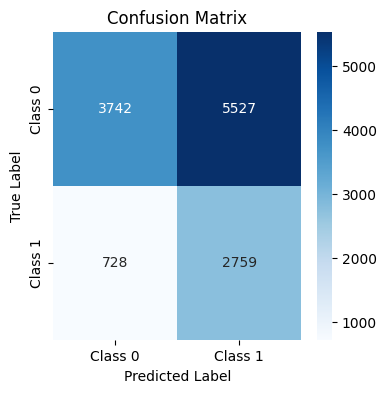

Доля банкротов 0.1628635346756152
% Одобрения 0.3504233301975541


In [58]:
preds_proba_cat = model.predict_proba(X_valid)[:, 1]
y_pred_class = (preds_proba_cat >= 0.422).astype(int)
precision = precision_score(y_valid, y_pred_class)
recall = recall_score(y_valid, y_pred_class)
f1 = f1_score(y_valid, y_pred_class)
auc_pred = roc_auc_score(y_valid, preds_proba_cat)

print(f"AUC: {auc_pred}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

conf(y_valid,y_pred_class)

In [ ]:
preds_proba_cat